In [0]:
from google.colab import drive
drive.mount('/content/gdrive')

In [0]:
from google.colab import files
uploaded = files.upload()

Saving DumbPredictor.py to DumbPredictor.py
Saving pollutant_features.csv to pollutant_features.csv
Saving weather_features.csv to weather_features.csv


In [0]:
from DumbPredictor import NullPredictor,MeanPredictor,PreviousPredictor

In [0]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import warnings
from sklearn.linear_model import LinearRegression,LassoCV, RidgeCV, Lasso, Ridge,MultiTaskLassoCV,MultiTaskLasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, make_scorer
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.linear_model import Ridge, Lasso

In [0]:
plt.style.use('default')

In [0]:
polluant_list = ['NO2','O3','PM10','PM2_5']
villes_list = ['PARIS','LYON','MADRID','BEIJING',]

In [0]:
meteo = pd.read_csv('weather_features.csv')

In [0]:
pollutant = pd.read_csv('pollutant_features.csv')

In [0]:
print(pollutant.shape,meteo.shape)

(139933, 6) (138312, 10)


# 1.Preprocessing

In [0]:
def shifted_dataset(initial_data,back_shift,forward_shift):
    #créer les données shiftées de 1,2,...,max_shift heures, et rajouter H+1 pour la meteo
    dataset = initial_data.copy()
    columns = dataset.columns
    columns = columns.drop(['date','zone'])
    for shift in np.arange(-back_shift,forward_shift+1):
        for feature in columns:
            shifted_feature = feature+'_H'+'+'*bool(shift>=0)+str(shift)
            dataset[shifted_feature] = dataset.sort_values(['zone','date']).groupby(['zone'])[feature].shift(-shift)
    dataset = dataset.drop(columns,axis=1)
    
    return dataset

In [0]:
  def forwardSeries(dataset,forward_shift):
    for feature in dataset.columns:
        if feature not in ['zone','date']:
            for shift in range(1,forward_shift+1):
                dataset[feature+'_H+'+str(shift)] = dataset.sort_values(['zone','date']).groupby(['zone'])[feature].shift(-shift)
            dataset = dataset.drop([feature],axis=1)    
    return dataset

In [0]:
def preprocess(ville, polluant,backward,forward,method,dataset,meteo_ds,ft_list='all'):
    """
    la méthode 'single' prédit sur uniquement t+forward
    la méthode 'series' prédit sur t+1,t+2,...,t+forward
    la méthode 'iter' prédit t+1 puis s'en sert pour prédire t+2 etc. jusqu'à t+forward
    """
    #prepare dataset, labels
    polluant_list = np.array(['O3','PM2_5','PM10','NO2'])
    to_drop = polluant_list[polluant_list!=polluant]
    
    pollutant = dataset[dataset.zone==ville].drop(to_drop,axis=1)
    if ft_list == 'all':
        meteo = meteo_ds.copy()[meteo_ds.zone==ville]
    else: 
        meteo = meteo_ds.copy()[meteo_ds.zone==ville][['zone','date']+ft_list]  
    m = len(meteo.columns.drop(['date','zone'])) #servira plus loin, normalement vaut 8
    
    #shift datasets    
    dfpoll = shifted_dataset(pollutant,backward,forward_shift=0)
    if method == 'single':
        dfmeteo = shifted_dataset(meteo,backward,forward_shift=1)
    elif method == 'series':
        dfmeteo = shifted_dataset(meteo,backward,forward_shift=forward)
    elif method == 'iter':
        dfmeteo = shifted_dataset(meteo,backward,forward_shift=forward)
    else:
        raise ValueError('method needs to be defined')
        
    df = pd.merge(dfpoll,dfmeteo,how = 'inner', on=['date']).drop_duplicates(subset='date')
    
    axes = df[['date']].drop_duplicates() #on garde pour restreindre les labels par la suite
    
    try:
        df = df.drop(['date','zone_x','zone_y'],axis=1)
    except:
        df = df.drop(['date','zone'],axis=1)
        
    df = df.fillna(method='bfill',axis=0)
    df = df.fillna(method='ffill',axis=0)
    
    #prepare labels 
    labels = forwardSeries(pollutant,forward).drop_duplicates(subset='date')
    labels = axes.merge(labels,how='inner',on=['date'])
    if method == 'single':
        labels = labels.drop(['date'],axis=1)[polluant+'_H+'+str(forward)]
    elif method == 'series' or method=='iter':
        labels = labels.drop(['date'],axis=1)[[polluant+'_H+'+str(i) for i in range(1,forward+1)]]
    
    labels = labels.fillna(method='bfill',axis=0)
    labels = labels.fillna(method='ffill',axis=0)
    
    return df,labels

# 2. Fonction d'évaluation

In [0]:
def evaluate1Ville1Poll(model,df,labels,forward,backward,method,ft_list='all'):

    splits = TimeSeriesSplit(n_splits=3)
    RMSE_list = []
    train_error = []
    df = df.values
    labels = labels.values
    if ft_list=='all':
      m=8
    else: 
      m = len(ft_list)
    
    for train,test in splits.split(df):
        
        if method == 'single' or method == 'series':
            model.fit(df[train],labels[train])
            t_e = model.fit(df[train],labels[train]).score(df[train],labels[train])
            train_error.append(t_e)
            ypred = model.predict(df[test])
            RMSE_list.append(np.sqrt(mean_squared_error(labels[test],ypred)))
            
        else: #method = 'iter'
            dftrain = df[train][:,:backward+m*(backward+1)+1]
            
            #compute train error
            if forward == 1:
                model.fit(dftrain,labels[train])
                t_e = np.sqrt(mean_squared_error(model.predict(dftrain),labels[train]))
                train_error.append(t_e)
            else:
                model.fit(dftrain,labels[train][:,0])
                t_e = np.sqrt(mean_squared_error(model.predict(dftrain),labels[train][:,0]))
                train_error.append(t_e)
            
            #compute test error
            dftest = df[test][:,:backward+m*(backward+1)+1]
            ypred = np.zeros(shape=(labels[test].shape[0],))
            for i in range(forward):
                ytemp = model.predict(dftest)
                ypred = np.column_stack((ypred,ytemp))
                dftest = np.column_stack((df[test][:,1:backward+1],ytemp,df[test][:,backward+1+m*i:backward+1+m*i+m*(backward+1)]))
               
            ypred = ypred[:,1:]
            RMSE_list.append(np.sqrt(mean_squared_error(labels[test].reshape((forward,len(test))), ypred.reshape((forward,len(test))),multioutput='raw_values')))
    RMSE_list = np.array(RMSE_list).ravel()
            
    return np.mean(RMSE_list),np.std(RMSE_list),np.percentile(RMSE_list,q=[25,75]),np.mean(train_error),np.std(train_error),np.percentile(train_error,q=[25,75])

In [0]:
df,labels = preprocess(ville='PARIS', polluant='NO2',backward=6,forward=24,method='iter',dataset=pollutant,meteo_ds=meteo)

In [0]:
evaluate1Ville1Poll(model=LinearRegression(),df=df,labels=labels,backward=6,forward=24,method='iter')

In [0]:
def evaluateModel(model,dataset,meteo_ds,forward,backward,ft_list='all'):
    """
    pour calculer les scores du modèle par ville et par polluant (tableau 4x4)
    """
    results = pd.DataFrame(np.zeros(shape=(len(villes_list),len(polluant_list))),
                           columns=polluant_list,
                           index=villes_list)
    results_var = pd.DataFrame(np.zeros(shape=(len(villes_list),len(polluant_list))),
                               columns=polluant_list,
                               index=villes_list)
    for polluant in polluant_list:
        print(polluant)
        for ville in villes_list:
            print(ville)
            
            df,labels = preprocess(ville=ville,
                       polluant=polluant,
                       backward=backward,
                       forward=forward,
                       method=method,
                       dataset=dataset,
                       meteo_ds=meteo_ds,
                       ft_list='all')
            
            scores = evaluate1Ville1Poll(
                                        model = model,
                                        backward = backward,
                                        forward = forward,
                                        method = method,
                                        df = df,
                                        labels = labels,
                                        ft_list = ft_list
                                    
                                        )
            results[polluant][ville] = scores[0]  
            results_var[polluant][ville] = scores[1]
                                           
    return results,results_var

In [0]:
def forwardGraph(ville, polluant,models,backward,forward,method,dataset,meteo_ds,names):
    
      
    colormap = plt.get_cmap('inferno')
    fig = plt.figure(figsize=(20,len(models)*3))
    n = int(np.ceil(len(models)/2))
    plt.title('RMSE en fonction du temps pour {} à {}'.format(polluant,ville))
    
    for j,model in enumerate(models):
        if len(models)==1:
          ax = fig.add_subplot(111)
        else:
          ax = fig.add_subplot(n,2,j+1)
          
        toplot_means = np.zeros((forward,))
        toplot_uq = np.zeros((forward,))
        toplot_lq = np.zeros((forward,))
        color = colormap(j/len(models))
        name = names[j]
        
        if method=='series':
          warnings.warn('there is a better function to do that')
          
        for i in range(1,forward+1):
            df,labels = preprocess(ville=ville,
                       polluant=polluant,
                       backward=backward,
                       forward=i,
                       method=method,
                       dataset=dataset,
                       meteo_ds=meteo_ds,
                       ft_list='all')
            
            scores = evaluate1Ville1Poll(
                                        model = model,
                                        backward = backward,
                                        forward = i,
                                        method = method,
                                        df = df,
                                        labels = labels
                                        )
            toplot_means[i-1] = scores[0]
            toplot_uq[i-1] = scores[2][0] #upper quantile
            toplot_lq[i-1] = scores[2][1] #lower quantile
        ax.plot(np.arange(1,forward+1),toplot_means,linewidth=2,c=color)
        ax.plot(np.arange(1,forward+1),toplot_uq,c = color,ls='dotted')
        ax.plot(np.arange(1,forward+1),toplot_lq,c=color,ls='dotted')
        ax.set_xlabel('time steps forward')
        ax.set_ylabel('RMSE')
        ax.fill_between(np.arange(1,forward+1),
                         toplot_lq,
                         toplot_uq,
                         facecolor = color,
                         alpha = 0.5)
        ax.grid(True)
        ax.set_title(name)
       
    return toplot_means

# 3. Benchmark

## 3.0 Fonctions auxiliaires

In [0]:
#Fonction manuelle mais qui marche
def find_lambda_pen_reg(model,ville,polluant,backward,forward,method,dataset,meteo_ds):
  df,labels = preprocess(ville, polluant,backward,forward,method,dataset,meteo_ds)
  if model == "ridge":
    model = RidgeCV(alphas=np.arange(3000,3200,10),cv=TimeSeriesSplit(3))
    model.fit(df,labels)
  if model == "lasso":
    if method == 'series':
      model = MultiTaskLassoCV(n_alphas=100,cv=TimeSeriesSplit(3))
    else: 
      model = LassoCV(n_alphas=100,cv=TimeSeriesSplit(3))
    model.fit(df,labels)
  return model.alpha_

In [0]:
def find_lambda_ridge(ville,polluant,backward,forward,method,dataset,meteo_ds,borne_inf,borne_sup,step,cv):
  df,labels = preprocess(ville, polluant,backward,forward,method,dataset,meteo_ds)
  model = RidgeCV(alphas=np.arange(borne_inf,borne_sup,step),cv=TimeSeriesSplit(cv))
  model.fit(df,labels)
  return model.alpha_

def find_lambda_lasso(ville,polluant,backward,forward,method,dataset,meteo_ds,borne_sup,cv):
  df,labels = preprocess(ville, polluant,backward,forward,method,dataset,meteo_ds)
  model = LassoCV(n_alphas=borne_sup,cv=TimeSeriesSplit(cv))
  model.fit(df,labels)
  return model.alpha_

In [0]:

def optimization_lasso_regression(ville,polluant,backward,forward,method,dataset,meteo_ds,borne_sup,cv):
  df,labels = preprocess(ville, polluant,backward,forward,method,dataset,meteo_ds)
  alpha_temp = find_lambda_lasso(ville,polluant,backward,forward,method,dataset,meteo_ds,borne_sup,cv)
  while alpha_temp == borne_sup:
    borne_sup = borne_sup + 50
    alpha_temp = find_lambda_lasso(ville,polluant,backward,forward,method,dataset,meteo_ds,borne_sup,cv)
  alpha_opt = alpha_temp
  return alpha_opt

def optimization_ridge_regression(ville,polluant,backward,forward,method,dataset,meteo_ds,borne_inf,borne_sup,step,cv):
  df,labels = preprocess(ville, polluant,backward,forward,method,dataset,meteo_ds)
  alpha_temp = find_lambda_ridge(ville,polluant,backward,forward,method,dataset,meteo_ds,borne_inf,borne_sup,step,cv)
  while (alpha_temp == borne_sup - step) | (alpha_temp == borne_inf + step):
    if alpha_temp == borne_sup - step:
      borne_inf = borne_sup
      borne_sup = borne_sup*(1 + 0.5)
      step = (borne_sup - borne_inf)/10
      alpha_temp = find_lambda_ridge(ville,polluant,backward,forward,method,dataset,meteo_ds,borne_inf,borne_sup,step,cv)
    if alpha_temp == borne_inf + step:
      borne_sup = borne_inf
      borne_inf = borne_sup*(1 - 0.5)
      step = (borne_sup - borne_inf)/10
      alpha_temp = find_lambda_ridge(ville,polluant,backward,forward,method,dataset,meteo_ds,borne_inf,borne_sup,step,cv)
    else : 
      borne_inf = alpha_temp - step
      borne_sup = alpha_temp + step
      step = (borne_sup - borne_inf)/10
      alpha_temp = find_lambda_ridge(ville,polluant,backward,forward,method,dataset,meteo_ds,borne_inf,borne_sup,step,cv)
  alpha_opt = alpha_temp
  return alpha_opt

In [0]:
print(optimization_lasso_regression('PARIS','NO2',6,24,'series',pollutant,meteo,10,3),optimization_ridge_regression('PARIS','NO2',6,1,'series',pollutant,meteo,2000,2500,100,3))

## 3.1 En prédiction itérative

Meilleurs $\alpha$ pour le Lasso, iter: 
-  paris NO2 0.7,
-  paris PM10 0.2,
-  bejing NO2 0.8,
-  beijing PM10 6,5

Meilleur $\alpha$ pour le Ridge, iter:
- paris NO2 3125
- paris PM10 4151
- beijing NO2 2275
- beijing PM10 11086

In [0]:
models_list = [NullPredictor(0),MeanPredictor(6),PreviousPredictor(6),LinearRegression(),Ridge(alpha=3130),Lasso(alpha=0.70),RandomForestRegressor()]

/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:27: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:27: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:27: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


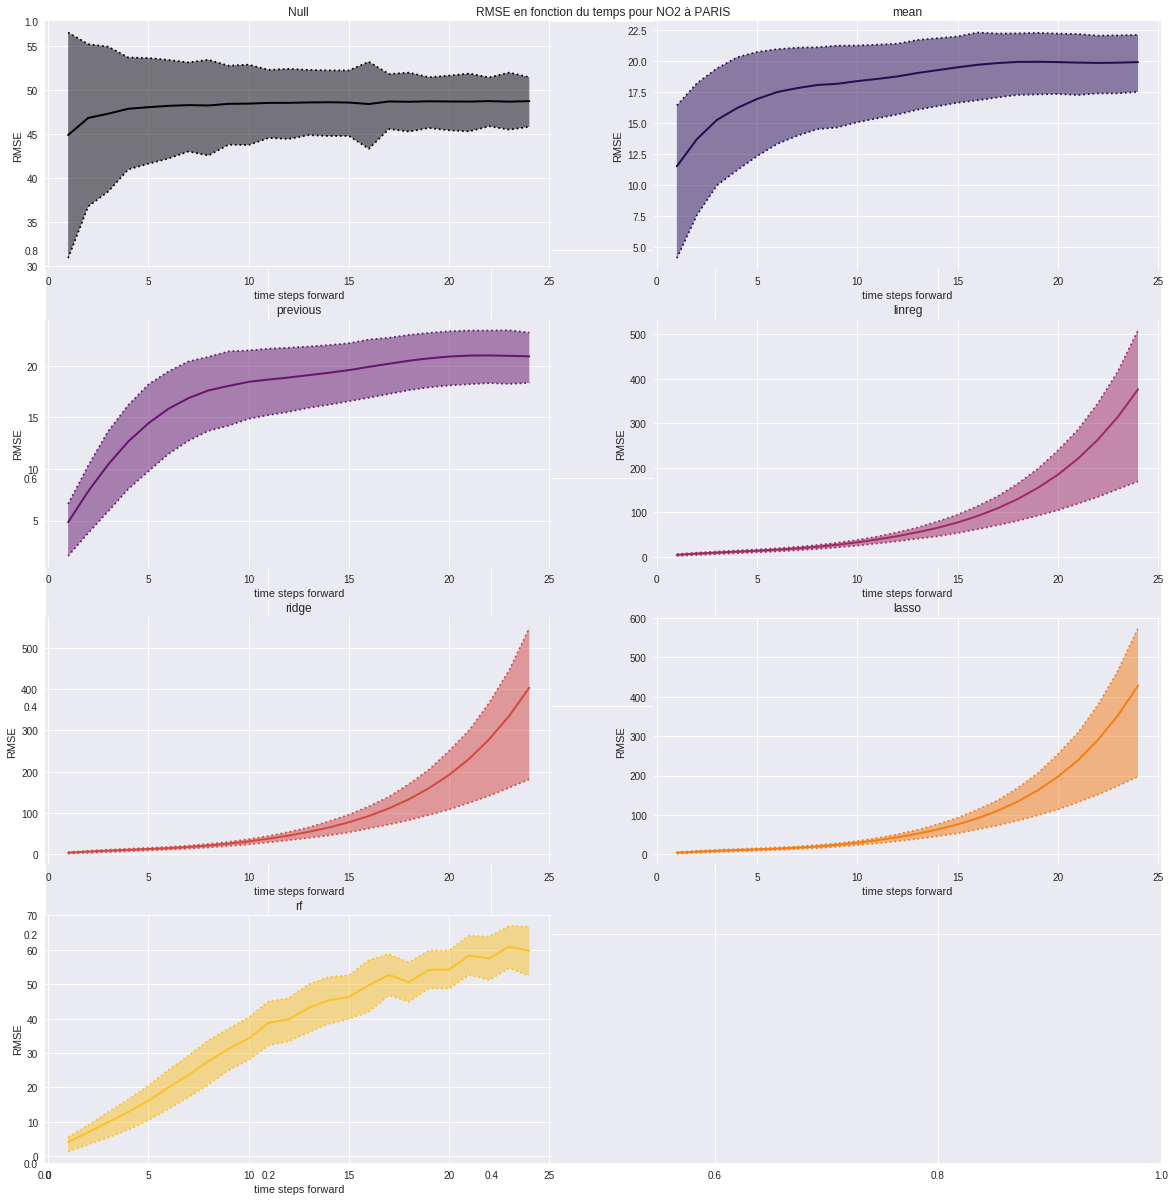

In [0]:
res = forwardGraph(ville='PARIS', polluant='NO2',models=models_list,
             backward=6,forward=24,
             method='iter',
             dataset=pollutant,
             meteo_ds=meteo,
             names = ['Null','mean','previous','linreg','ridge','lasso','rf'])

Fonction qui présente l'importance des features ainsi que la valeur des coefficients selon la ville et le polluant

In [0]:
def penalized_regression_detailed(ville, polluant,backward,forward,model,method,dataset,meteo_ds,ft_list='all'):
    #model = Lasso ou Ridge (sans ())
    polluant_list = np.array(['O3','PM2_5','PM10','NO2'])
    to_drop = polluant_list[polluant_list!=polluant]
    
    pollutant = dataset[dataset.zone==ville].drop(to_drop,axis=1)
    if ft_list == 'all':
        meteo = meteo_ds.copy()[meteo_ds.zone==ville]
    else: 
        meteo = meteo_ds.copy()[meteo_ds.zone==ville][['zone','date']+ft_list]  
    m = len(meteo.columns.drop(['date','zone'])) #servira plus loin, normalement vaut 8
    
    #shift datasets    
    dfpoll = shifted_dataset(pollutant,backward,forward_shift=0)
    if method == 'single' or method == 'series':
        dfmeteo = shifted_dataset(meteo,backward,forward_shift=1)
    elif method == 'iter':
        dfmeteo = shifted_dataset(meteo,backward,forward_shift=forward)
    else:
        raise ValueError('method needs to be defined')
        
    df = pd.merge(dfpoll,dfmeteo,how = 'inner', on=['date']).drop_duplicates(subset='date')
    
    axes = df[['date']].drop_duplicates() #on garde pour restreindre les labels par la suite
    
    try:
        df = df.drop(['date','zone_x','zone_y'],axis=1)
    except:
        df = df.drop(['date','zone'],axis=1)
        
    df = df.fillna(method='bfill',axis=0)
    df = df.fillna(method='ffill',axis=0)
    
    #prepare labels 
    labels = forwardSeries(pollutant,forward).drop_duplicates(subset='date')
    labels = axes.merge(labels,how='inner',on=['date'])
    if method == 'single':
        labels = labels.drop(['date'],axis=1)[polluant+'_H+'+str(forward)]
    elif method == 'series' or method=='iter':
        labels = labels.drop(['date'],axis=1)[[polluant+'_H+'+str(i) for i in range(1,forward+1)]]
    
    labels = labels.fillna(method='bfill',axis=0)
    labels = labels.fillna(method='ffill',axis=0)
    
    n_lambdas = 100
    lambdas = np.logspace(7.5,9, n_lambdas)
    coefs = []
    liste_var = meteo.columns.drop(['date','zone'])
    coefs_sum = pd.DataFrame(np.zeros(shape=(len(liste_var),len(lambdas))),columns=lambdas,index=liste_var)
    
    for a in lambdas:
      mod = model(alpha=a, fit_intercept=False)
      mod.fit(df,labels[polluant+'_H+'+str(forward)])
      coefs.append(mod.coef_)
      temp = pd.DataFrame({'Variables':df.columns,'Coefficients':mod.coef_})
      for var_name in liste_var:
        coefs_sum[a][var_name] = ((temp[temp["Variables"].str.contains(var_name)]["Coefficients"])**2).sum()
     
    coefs_sum.T.plot()
    plt.grid(True)
    plt.xlabel('Pénalisation')
    plt.ylabel('Valeurs coefficients')
    plt.xticks(np.logspace(7.5,9,3),["3.1 e+07", "1.7 e+08", "1 e+09"], fontsize=8,rotation=45)
    return coefs_sum

In [0]:
t = penalized_regression_detailed('PARIS', 'NO2',6,24,Ridge,'iter',pollutant,meteo,ft_list='all')

In [0]:
def penalized_regression_detailed_tempo(ville, polluant,backward,forward,model,method,dataset,meteo_ds,ft_list='all'):
    #model = Lasso ou Ridge (sans ())
    polluant_list = np.array(['O3','PM2_5','PM10','NO2'])
    to_drop = polluant_list[polluant_list!=polluant]
    
    pollutant = dataset[dataset.zone==ville].drop(to_drop,axis=1)
    if ft_list == 'all':
        meteo = meteo_ds.copy()[meteo_ds.zone==ville]
    else: 
        meteo = meteo_ds.copy()[meteo_ds.zone==ville][['zone','date']+ft_list]  
    m = len(meteo.columns.drop(['date','zone'])) #servira plus loin, normalement vaut 8
    
    #shift datasets    
    dfpoll = shifted_dataset(pollutant,backward,forward_shift=0)
    if method == 'single' or method == 'series':
        dfmeteo = shifted_dataset(meteo,backward,forward_shift=1)
    elif method == 'iter':
        dfmeteo = shifted_dataset(meteo,backward,forward_shift=forward)
    else:
        raise ValueError('method needs to be defined')
        
    df = pd.merge(dfpoll,dfmeteo,how = 'inner', on=['date']).drop_duplicates(subset='date')
    
    axes = df[['date']].drop_duplicates() #on garde pour restreindre les labels par la suite
    
    try:
        df = df.drop(['date','zone_x','zone_y'],axis=1)
    except:
        df = df.drop(['date','zone'],axis=1)
        
    df = df.fillna(method='bfill',axis=0)
    df = df.fillna(method='ffill',axis=0)
    
    #prepare labels 
    labels = forwardSeries(pollutant,forward).drop_duplicates(subset='date')
    labels = axes.merge(labels,how='inner',on=['date'])
    if method == 'single':
        labels = labels.drop(['date'],axis=1)[polluant+'_H+'+str(forward)]
    elif method == 'series' or method=='iter':
        labels = labels.drop(['date'],axis=1)[[polluant+'_H+'+str(i) for i in range(1,forward+1)]]
    
    labels = labels.fillna(method='bfill',axis=0)
    labels = labels.fillna(method='ffill',axis=0)
    
    n_lambdas = 100
    lambdas = np.logspace(13.5,14.5, n_lambdas)
    coefs = []
    liste_var = ['H'+'+'*int(i>=0)+str(i) for i in range(-6,0)]
    coefs_sum = pd.DataFrame(np.zeros(shape=(len(liste_var),len(lambdas))),columns=lambdas,index=liste_var)
    
    for a in lambdas:
      mod = model(alpha=a, fit_intercept=False)
      mod.fit(df,labels[polluant+'_H+'+str(forward)])
      coefs.append(mod.coef_)
      temp = pd.DataFrame({'Variables':df.columns,'Coefficients':mod.coef_})
      for var_name in liste_var:
        coefs_sum[a][var_name] = ((temp[temp["Variables"].str.contains(var_name)]["Coefficients"])**2).sum()
    
    colors= iter(cm.rainbow(np.linspace(0,1,31)))
    coefs_sum.T.plot(color = colors, alpha=0.5)
    plt.grid(True)
    plt.xlabel('Pénalisation')
    plt.ylabel('Valeurs coefficients')
    plt.xticks(np.logspace(12.5,14.5,3),["3 e+10", "3 e+11", "3 e+12"], fontsize=8,rotation=45)
    plt.legend(ncol=5,columnspacing=1.0, labelspacing=0.1,handletextpad=0.0, handlelength=1.5)
    
    return coefs_sum

In [0]:
t2 = penalized_regression_detailed_tempo('PARIS','NO2',6,24,Ridge,'iter',pollutant,meteo,ft_list='all')

# 4. Optimisation d'une RF

On commence par une optimisation avec hyperopt pour optimiser la RMSE de l'ensemble de la prédiction

In [0]:
df,labels = preprocess(ville='PARIS', polluant='NO2',backward=6,forward=24,method='iter',dataset=pollutant,meteo_ds=meteo)

In [0]:
evaluate1Ville1Poll(model=LinearRegression(),df=df,labels=labels,forward=24,backward=6,method='iter')

(1,)
(2,)
(3,)


(393.22100580283313,
 201.49596570957812,
 array([266.21070064, 512.64145916]),
 9.77086861050489,
 1.6056813942016621,
 array([ 8.68242562, 10.5949091 ]))

In [0]:
dfi = df.values
labelsi = labels.values

In [0]:
n_estimators = [10,100]
max_features = ['auto', 'sqrt']
max_depth = [10,50]
min_samples_split = [2,10,50]
min_samples_leaf = [1,10]
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf}
ts_cv = TimeSeriesSplit(3).split(dfi)
grid = GridSearchCV(RandomForestRegressor(random_state=0), random_grid, n_jobs=-1, cv=ts_cv,verbose=10)
grid.fit(dfi[:,:6+8*(6+1)+1],labelsi[:,0])

Fitting 3 folds for each of 48 candidates, totalling 144 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    4.1s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:   33.9s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:  3.2min
[Parallel(n_jobs=-1)]: Done  21 tasks      | elapsed:  5.0min
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:  6.6min
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:  9.0min
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:  9.6min
[Parallel(n_jobs=-1)]: Done  57 tasks      | elapsed:  9.8min
[Parallel(n_jobs=-1)]: Done  68 tasks      | elapsed: 10.2min
/usr/local/lib/python3.6/dist-packages/sklearn/externals/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
[Parallel(

GridSearchCV(cv=<generator object TimeSeriesSplit.split at 0x7f5c6a1a2830>,
       error_score='raise-deprecating',
       estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=None,
           oob_score=False, random_state=0, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'n_estimators': [10, 100], 'max_features': ['auto', 'sqrt'], 'max_depth': [10, 50], 'min_samples_split': [2, 10, 50], 'min_samples_leaf': [1, 10]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=10)

In [0]:
grid.best_params_

{'max_depth': 50,
 'max_features': 'auto',
 'min_samples_leaf': 10,
 'min_samples_split': 2,
 'n_estimators': 100}

In [0]:
best_rf = RandomForestRegressor(n_estimators=100,min_samples_split= 500,min_samples_leaf=700,max_depth=30,max_features='auto',random_state=0)

(30367, 71) (30367, 1)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:27: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:27: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:27: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


(30367, 79) (30367, 2)
(30367, 87) (30367, 3)
(30367, 95) (30367, 4)
(30367, 103) (30367, 5)
(30367, 111) (30367, 6)
(30367, 119) (30367, 7)
(30367, 127) (30367, 8)
(30367, 135) (30367, 9)
(30367, 143) (30367, 10)
(30367, 151) (30367, 11)
(30367, 159) (30367, 12)
(30367, 167) (30367, 13)
(30367, 175) (30367, 14)
(30367, 183) (30367, 15)
(30367, 191) (30367, 16)
(30367, 199) (30367, 17)
(30367, 207) (30367, 18)
(30367, 215) (30367, 19)
(30367, 223) (30367, 20)
(30367, 231) (30367, 21)
(30367, 239) (30367, 22)
(30367, 247) (30367, 23)
(30367, 255) (30367, 24)


array([ 7.40296087, 10.09515595, 12.33966473, 14.20563963, 15.71812072,
       16.90432702, 17.79752225, 18.43974582, 18.88626139, 19.18796186,
       19.39707909, 19.56642647, 19.73973579, 19.94272003, 20.18298295,
       20.45263676, 20.73554133, 21.0082526 , 21.24302844, 21.41796336,
       21.52041281, 21.55111424, 21.52828993, 21.48635911])

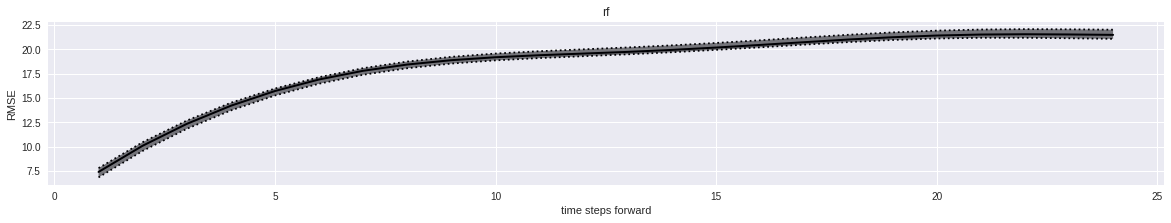

In [0]:
forwardGraph(ville='PARIS',polluant='NO2',models=[best_rf],dataset=pollutant,meteo_ds=meteo,forward=24,backward=6,method='iter',names=['rf'])


In [0]:
forwardGraph(ville='PARIS',polluant='NO2',models=[best_rf],dataset=pollutant,meteo_ds=meteo,forward=24,backward=6,method='series',names=['rf avec méthode séries'])

#Modèle agrégé

In [0]:
best_rf = RandomForestRegressor(n_estimators=100,min_samples_split= 500,min_samples_leaf=700,max_depth=30,max_features='auto',random_state=0)

In [0]:
def seriesForwardGraphagregatedvs(ville_test,polluant,model_agreg,model_sep,backward,forward,dataset,meteo_ds,names):
  
  df_p, labels_p = preprocess('PARIS',polluant,backward,forward,'series',pollutant,meteo)
  df_b, labels_b = preprocess('BEIJING',polluant,backward,forward,'series',pollutant,meteo)
  df_l, labels_l = preprocess('LYON',polluant,backward,forward,'series',pollutant,meteo)
  df_m, labels_m = preprocess('MADRID',polluant,backward,forward,'series',pollutant,meteo)

  
  splits = TimeSeriesSplit(n_splits=3)
  df_p = df_p.values
  labels_p = labels_p.values
  df_b = df_b.values
  labels_b = labels_b.values
  df_l = df_l.values
  labels_l = labels_l.values
  df_m = df_m.values
  labels_m = labels_m.values
  
  fig = plt.figure()
  
    
  #plt.title('RMSE en fonction du temps pour {} à {}'.format(polluant,ville))
  colormap = plt.get_cmap('inferno')
  colormap = plt.get_cmap('Blues_r')
  plt.grid(True)
  
  
  RMSE_sep = np.zeros(forward)
  RMSE_agreg = np.zeros(forward)
  for (train_p,test_p),(train_b,test_b),(train_l,test_l),(train_m,test_m) in zip(splits.split(df_p),splits.split(df_b),splits.split(df_l),splits.split(df_m)):

      dftrain = []
      labelstrain = []
      dftest = []
      labelstest = []

      dftrain = np.concatenate((df_p[train_p],df_b[train_b],df_l[train_l],df_m[train_m]), axis=0)
      labelstrain = np.concatenate((labels_p[train_p],labels_b[train_b],labels_l[train_l],labels_m[train_m]), axis=0)

        
      if ville_test == 'PARIS':
        dftest = df_p[test_p]
        labelstest = labels_p[test_p]
        dftrain_sep = df_p[train_p]
        ltrain_sep = labels_p[train_p]

      if ville_test == 'BEIJING':
        dftest = df_b[test_b]
        labelstest = labels_b[test_b]
        dftrain_sep = df_b[train_b]
        ltrain_sep = labels_b[train_b]

      if ville_test == 'LYON':
        dftest = df_l[test_l]
        labelstest = labels_l[test_l]
        dftrain_sep = df_l[train_l]
        ltrain_sep = labels_l[train_l]

      if ville_test == 'MADRID':
        dftest = df_m[test_m]
        labelstest = labels_m[test_m]
        dftrain_sep = df_m[train_m]
        ltrain_sep = labels_m[train_m]

      rbase = np.zeros((len(dftest),1))

      model_agreg.fit(dftrain,labelstrain)
      ypred = model_agreg.predict(dftest)
      model_sep.fit(dftrain_sep,ltrain_sep)
      ypred_sep = model_sep.predict(dftest)

      for i in range(1,forward+1):
        if i==1:
          r = np.sqrt((labelstest[:,:i]-ypred[:,:i])**2)

        else:
          ytrue = labelstest[:,:i].reshape((i,len(labelstest)))
          ypred_restr = ypred[:,:i].reshape((i,len(labelstest)))
          r = np.sqrt(mean_squared_error(ytrue,ypred_restr,multioutput='raw_values'))
        rbase = np.column_stack((rbase,r.reshape((len(r),1))))

      RMSE_agreg = np.row_stack((RMSE_agreg,rbase[:,1:]))

      rbase = np.zeros((len(dftest),1))
      for i in range(1,forward+1):
        if i==1:
          r = np.sqrt((labelstest[:,:i]-ypred_sep[:,:i])**2)

        else:
          ytrue = labelstest[:,:i].reshape((i,len(labelstest)))
          ypred_restr = ypred_sep[:,:i].reshape((i,len(labelstest)))
          r = np.sqrt(mean_squared_error(ytrue,ypred_restr,multioutput='raw_values'))
        rbase = np.column_stack((rbase,r.reshape((len(r),1))))

      RMSE_sep = np.row_stack((RMSE_sep,rbase[:,1:]))
        

  RMSE_agreg = RMSE_agreg[1:]
  RMSE_sep = RMSE_sep[1:]
  
  rmse_ma = np.mean(RMSE_agreg,axis=0)
  rmse_uqa = np.percentile(RMSE_agreg,axis=0,q=75)
  rmse_lqa = np.percentile(RMSE_agreg,axis=0,q=25)
  
  rmse_ms = np.mean(RMSE_sep,axis=0)
  rmse_uqs = np.percentile(RMSE_sep,axis=0,q=75)
  rmse_lqs = np.percentile(RMSE_sep,axis=0,q=25)
  
  
  ax = fig.add_subplot(111)
  
  ax.plot(np.arange(1,forward+1),rmse_ma,linewidth=2,c='b',label='agrégé')
  ax.plot(np.arange(1,forward+1),rmse_uqa,c = 'b',ls='dotted')
  ax.plot(np.arange(1,forward+1),rmse_lqa,c = 'b',ls='dotted')
  
  ax.plot(np.arange(1,forward+1),rmse_ms,linewidth=2,c='r',label='spécifique')
  ax.plot(np.arange(1,forward+1),rmse_uqs,c = 'r',ls='dotted')
  ax.plot(np.arange(1,forward+1),rmse_lqs,c = 'r',ls='dotted')
  
  ax.set_xlabel('horizon temporel')
  ax.set_ylabel('RMSE')
  #ax.fill_between(np.arange(1,forward+1),
  #                   rmse_lq,
  #                   rmse_uq,
  #                   facecolor = color,
  #                   alpha = 0.5)
 

  return None 

/usr/local/lib/python3.6/dist-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "


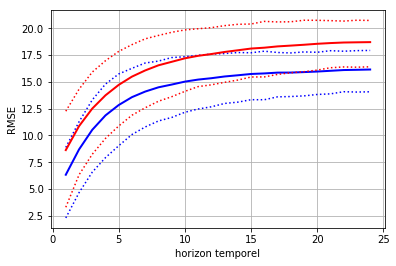

In [0]:
seriesForwardGraphagregatedvs(ville_test='PARIS',polluant='NO2',model_agreg=best_rf,model_sep=best_rf,
                              backward=6,forward=24,dataset=pollutant,meteo_ds=meteo,names=[])

/usr/local/lib/python3.6/dist-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "


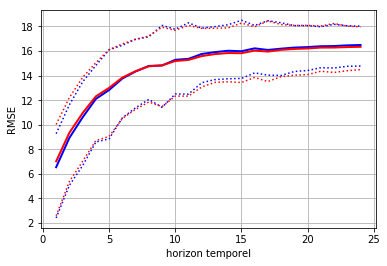

In [0]:
seriesForwardGraphagregatedvs(ville_test='LYON',polluant='NO2',model_agreg=best_rf,model_sep=best_rf,
                              backward=6,forward=24,dataset=pollutant,meteo_ds=meteo,names=[])

/usr/local/lib/python3.6/dist-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "


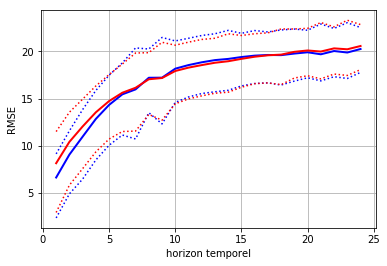

In [0]:
seriesForwardGraphagregatedvs(ville_test='BEIJING',polluant='NO2',model_agreg=best_rf,model_sep=best_rf,
                              backward=6,forward=24,dataset=pollutant,meteo_ds=meteo,names=[])

In [0]:
#Modèle agrégé entraîné sur les 4 villes
def seriesForwardGraphagregatedfinal(ville_test,polluant,models,backward,forward,dataset,meteo_ds,names):
  
  df_p, labels_p = preprocess('PARIS',polluant,backward,forward,'series',pollutant,meteo)
  df_b, labels_b = preprocess('BEIJING',polluant,backward,forward,'series',pollutant,meteo)
  df_l, labels_l = preprocess('LYON',polluant,backward,forward,'series',pollutant,meteo)
  df_m, labels_m = preprocess('MADRID',polluant,backward,forward,'series',pollutant,meteo)

  
  splits = TimeSeriesSplit(n_splits=3)
  df_p = df_p.values
  labels_p = labels_p.values
  df_b = df_b.values
  labels_b = labels_b.values
  df_l = df_l.values
  labels_l = labels_l.values
  df_m = df_m.values
  labels_m = labels_m.values
  
  fig = plt.figure(figsize=(20,len(models)*3))
  n = int(np.ceil(len(models)/2))
  if n>1:
    fig = plt.figure(figsize=(20,len(models)*3))
  else: 
    fig = plt.figure(figsize=(5,len(models)*3))
    
  #plt.title('RMSE en fonction du temps pour {} à {}'.format(polluant,ville))
  colormap = plt.get_cmap('inferno')
  colormap = plt.get_cmap('Blues_r')
  plt.grid(True)
  
  for j,model in enumerate(models): 
    
    RMSE_list = np.zeros(forward)
    for (train_p,test_p),(train_b,test_b),(train_l,test_l),(train_m,test_m) in zip(splits.split(df_p),splits.split(df_b),splits.split(df_l),splits.split(df_m)):
      
        dftrain = []
        labelstrain = []
        dftest = []
        labelstest = []
        
        dftrain = np.concatenate((df_p[train_p],df_b[train_b],df_l[train_l],df_m[train_m]), axis=0)
        labelstrain = np.concatenate((labels_p[train_p],labels_b[train_b],labels_l[train_l],labels_m[train_m]), axis=0)
        
        if ville_test == 'PARIS':
          dftest = df_p[test_p]
          labelstest = labels_p[test_p]
        if ville_test == 'BEIJING':
          dftest = df_b[test_b]
          labelstest = labels_b[test_b]
        if ville_test == 'LYON':
          dftest = df_l[test_l]
          labelstest = labels_l[test_l]
        if ville_test == 'MADRID':
          dftest = df_m[test_m]
          labelstest = labels_m[test_m]

        rbase = np.zeros((len(dftest),1))
        model.fit(dftrain,labelstrain)
        ypred = model.predict(dftest)
        for i in range(1,forward+1):
          if i==1:
            r = np.sqrt((labelstest[:,:i]-ypred[:,:i])**2)
          else:
            ytrue = labelstest[:,:i].reshape((i,len(labelstest)))
            ypred_restr = ypred[:,:i].reshape((i,len(labelstest)))
            r = np.sqrt(mean_squared_error(ytrue,ypred_restr,multioutput='raw_values'))
          rbase = np.column_stack((rbase,r.reshape((len(r),1)))) 
        RMSE_list = np.row_stack((RMSE_list,rbase[:,1:]))
      
  rl = RMSE_list[1:]
  rmse_m = np.mean(rl,axis=0)
  rmse_uq = np.percentile(rl,axis=0,q=75)
  rmse_lq = np.percentile(rl,axis=0,q=25)
  if n>1:
    ax = fig.add_subplot(n,2,j+1)
  else: 
    ax = fig.add_subplot(111)
  color = colormap(j/len(models))
  name = names[j]
  ax.plot(np.arange(1,forward+1),rmse_m,linewidth=2,c=color)
  ax.plot(np.arange(1,forward+1),rmse_uq,c = color,ls='dotted')
  ax.plot(np.arange(1,forward+1),rmse_lq,c=color,ls='dotted')
  ax.set_xlabel('horizon temporel')
  ax.set_ylabel('RMSE')
  ax.fill_between(np.arange(1,forward+1),
                     rmse_lq,
                     rmse_uq,
                     facecolor = color,
                     alpha = 0.5)
  ax.set_title(name)

  return None 

In [0]:
#Modèle agrégé entraîné sur Paris et Beijing
def seriesForwardGraphagregated(ville_test,polluant,models,backward,forward,dataset,meteo_ds,names):
  
  df_p, labels_p = preprocess('PARIS',polluant,backward,forward,'series',pollutant,meteo)
  df_b, labels_b = preprocess('BEIJING',polluant,backward,forward,'series',pollutant,meteo)
    
  splits = TimeSeriesSplit(n_splits=3)
  df_p = df_p.values
  labels_p = labels_p.values
  df_b = df_b.values
  labels_b = labels_b.values
  
  fig = plt.figure(figsize=(20,len(models)*3))
  n = int(np.ceil(len(models)/2))
  plt.title('RMSE en fonction du temps pour {}'.format(polluant))
  colormap = plt.get_cmap('inferno')
  
  for j,model in enumerate(models): 
    
    RMSE_list = np.zeros(forward)
    for (train_p,test_p),(train_b,test_b) in zip(splits.split(df_p),splits.split(df_b)):
      
        dftrain = []
        labelstrain = []
        dftest = []
        labelstest = []
        
        dftrain = np.concatenate((df_p[train_p],df_b[train_b]), axis=0)
        labelstrain = np.concatenate((labels_p[train_p],labels_b[train_b]), axis=0)
      
        if ville_test == 'PARIS':
          dftest = df_p[test_p]
          labelstest = labels_p[test_p]
        if ville_test == 'BEIJING':
          dftest = df_b[test_b]
          labelstest = labels_b[test_b]
        
        rbase = np.zeros((len(dftest),1))
        model.fit(dftrain,labelstrain)
        ypred = model.predict(dftest)
        for i in range(1,forward+1):
          if i==1:
            r = np.sqrt((labelstest[:,:i]-ypred[:,:i])**2)
          else:
            ytrue = labelstest[:,:i].reshape((i,len(labelstest)))
            ypred_restr = ypred[:,:i].reshape((i,len(labelstest)))
            r = np.sqrt(mean_squared_error(ytrue,ypred_restr,multioutput='raw_values'))
          rbase = np.column_stack((rbase,r.reshape((len(r),1)))) 
        RMSE_list = np.row_stack((RMSE_list,rbase[:,1:]))
      
  rl = RMSE_list[1:]
  rmse_m = np.mean(rl,axis=0)
  rmse_uq = np.percentile(rl,axis=0,q=75)
  rmse_lq = np.percentile(rl,axis=0,q=25)
    
  ax = fig.add_subplot(n,2,j+1)
  color = colormap(j/len(models))
  name = names[j]
  ax.plot(np.arange(1,forward+1),rmse_m,linewidth=2,c=color)
  ax.plot(np.arange(1,forward+1),rmse_uq,c = color,ls='dotted')
  ax.plot(np.arange(1,forward+1),rmse_lq,c=color,ls='dotted')
  ax.set_xlabel('time steps forward')
  ax.set_ylabel('RMSE')
  ax.fill_between(np.arange(1,forward+1),
                     rmse_lq,
                     rmse_uq,
                     facecolor = color,
                     alpha = 0.5)
  ax.grid(True)
  ax.set_title(name)

  return None 

In [0]:
#Modèle entraîné sur Paris et Lyon
def seriesForwardGraphagregated2(ville_test,polluant,models,backward,forward,dataset,meteo_ds,names):
  
  df_p, labels_p = preprocess('PARIS',polluant,backward,forward,'series',pollutant,meteo)
  df_b, labels_b = preprocess('LYON',polluant,backward,forward,'series',pollutant,meteo)
    
  splits = TimeSeriesSplit(n_splits=3)
  df_p = df_p.values
  labels_p = labels_p.values
  df_b = df_b.values
  labels_b = labels_b.values
  
  fig = plt.figure(figsize=(20,len(models)*3))
  n = int(np.ceil(len(models)/2))
  plt.title('RMSE en fonction du temps pour {}'.format(polluant))
  colormap = plt.get_cmap('inferno')
  
  for j,model in enumerate(models): 
    
    RMSE_list = np.zeros(forward)
    for (train_p,test_p),(train_b,test_b) in zip(splits.split(df_p),splits.split(df_b)):
      
        dftrain = []
        labelstrain = []
        dftest = []
        labelstest = []
        
        dftrain = np.concatenate((df_p[train_p],df_b[train_b]), axis=0)
        labelstrain = np.concatenate((labels_p[train_p],labels_b[train_b]), axis=0)
      
        if ville_test == 'PARIS':
          dftest = df_p[test_p]
          labelstest = labels_p[test_p]
        if ville_test == 'LYON':
          dftest = df_b[test_b]
          labelstest = labels_b[test_b]
        
        rbase = np.zeros((len(dftest),1))
        model.fit(dftrain,labelstrain)
        ypred = model.predict(dftest)
        for i in range(1,forward+1):
          if i==1:
            r = np.sqrt((labelstest[:,:i]-ypred[:,:i])**2)
          else:
            ytrue = labelstest[:,:i].reshape((i,len(labelstest)))
            ypred_restr = ypred[:,:i].reshape((i,len(labelstest)))
            r = np.sqrt(mean_squared_error(ytrue,ypred_restr,multioutput='raw_values'))
          rbase = np.column_stack((rbase,r.reshape((len(r),1)))) 
        RMSE_list = np.row_stack((RMSE_list,rbase[:,1:]))
      
  rl = RMSE_list[1:]
  rmse_m = np.mean(rl,axis=0)
  rmse_uq = np.percentile(rl,axis=0,q=75)
  rmse_lq = np.percentile(rl,axis=0,q=25)
    
  ax = fig.add_subplot(n,2,j+1)
  color = colormap(j/len(models))
  name = names[j]
  ax.plot(np.arange(1,forward+1),rmse_m,linewidth=2,c=color)
  ax.plot(np.arange(1,forward+1),rmse_uq,c = color,ls='dotted')
  ax.plot(np.arange(1,forward+1),rmse_lq,c=color,ls='dotted')
  ax.set_xlabel('time steps forward')
  ax.set_ylabel('RMSE')
  ax.fill_between(np.arange(1,forward+1),
                     rmse_lq,
                     rmse_uq,
                     facecolor = color,
                     alpha = 0.5)
  ax.grid(True)
  ax.set_title(name)

  return None 

# 5. LSTM

In [0]:
from keras import Sequential
from keras.layers import LSTM, Activation, Dense

In [0]:
df,labels = preprocess(ville='PARIS',polluant='NO2',backward=6,forward=24,method='series',dataset=pollutant,meteo_ds=meteo)
dfi,labelsi = df.values,labels.values

In [0]:
df.columns
for i in range (1,24+1):
  filled = df.insert(loc=6+i,column='NO2_H+'+str(i),value=0)

In [0]:
cols = list(df.columns[31:])
cols_split = [c.split('_') for c in cols ]

In [0]:
cols_split.sort(key = lambda x:x[0])

In [0]:
print(cols_split)

[['cloudcover', 'H-6'], ['cloudcover', 'H-5'], ['cloudcover', 'H-4'], ['cloudcover', 'H-3'], ['cloudcover', 'H-2'], ['cloudcover', 'H-1'], ['cloudcover', 'H+0'], ['cloudcover', 'H+1'], ['cloudcover', 'H+2'], ['cloudcover', 'H+3'], ['cloudcover', 'H+4'], ['cloudcover', 'H+5'], ['cloudcover', 'H+6'], ['cloudcover', 'H+7'], ['cloudcover', 'H+8'], ['cloudcover', 'H+9'], ['cloudcover', 'H+10'], ['cloudcover', 'H+11'], ['cloudcover', 'H+12'], ['cloudcover', 'H+13'], ['cloudcover', 'H+14'], ['cloudcover', 'H+15'], ['cloudcover', 'H+16'], ['cloudcover', 'H+17'], ['cloudcover', 'H+18'], ['cloudcover', 'H+19'], ['cloudcover', 'H+20'], ['cloudcover', 'H+21'], ['cloudcover', 'H+22'], ['cloudcover', 'H+23'], ['cloudcover', 'H+24'], ['precipintensity', 'H-6'], ['precipintensity', 'H-5'], ['precipintensity', 'H-4'], ['precipintensity', 'H-3'], ['precipintensity', 'H-2'], ['precipintensity', 'H-1'], ['precipintensity', 'H+0'], ['precipintensity', 'H+1'], ['precipintensity', 'H+2'], ['precipintensity',

In [0]:
corrected_cols = []
for vec in cols_split:
  corrected_cols.append(vec[0]+'_'+vec[1])
corrected_cols

In [0]:
cols = list(df.columns[:31])+corrected_cols
cols

In [0]:
dfi_r = df[cols].values

In [0]:
dfi_r = dfi_r.reshape((len(df),31,9))

In [0]:
model = Sequential()
model.add(LSTM(10, input_shape=(31,9), activation='relu'))
model.add(Dense(24))

In [0]:
model.compile(optimizer = 'adam',loss='mean_squared_error')
model.fit(dfi_r,labelsi,epochs=10,batch_size=10)

In [0]:
model.evaluate(dftrain,labelsi[:,0])

30367/30367 [==============================] - 1s 36us/step


3279.781835601442

# Réseau de neurones simple

In [0]:
from keras import Sequential
from keras.layers import Dense
from keras.callbacks import EarlyStopping,ModelCheckpoint

In [0]:
def evaluateNN(model,df,labels,forward,backward,method,ft_list='all'):

    splits = TimeSeriesSplit(n_splits=3)
    RMSE_list = []
    df = df.values
    labels = labels.values
    if ft_list=='all':
      m=8
    else: 
      m = len(ft_list)
    
    for train,test in splits.split(df):
      
        callbacks = [EarlyStopping(monitor='val_loss', mode='min'),
                     ModelCheckpoint(filepath='best_model.h5', monitor='val_loss', save_best_only=True)]    
        #model.fit(df[train],labels[train],callbacks=callbacks,epochs=200)
        model.fit(df[train],labels[train],epochs=500,verbose=0)
        ypred = model.predict(df[test])
        RMSE_list.append(np.sqrt(mean_squared_error(labels[test],ypred)))
            
    return np.mean(RMSE_list)

In [0]:
def forwardNN(model,ville,polluant, backward,forward,dataset,meteo_ds):
  
  df,labels = preprocess(ville=ville,polluant=polluant,
                         backward=backward,forward=forward,
                         dataset=dataset,meteo_ds=meteo_ds,
                         method='series')
  df,labels = df.values,labels.values
 
  colormap = plt.get_cmap('Blues_r')
  plt.grid(True)
  
    
  RMSE_list = np.zeros(forward)
  for train, test in TimeSeriesSplit(3).split(df):
    rbase = np.zeros((len(test),1))
    model.fit(df[train],labels[train],epochs=100,verbose=0)
    ypred = model.predict(df[test])
    for i in range(1,forward+1):
      if i==1:
        r = np.sqrt((labels[test][:,:i]-ypred[:,:i])**2)
      else:
        ytrue = labels[test][:,:i].reshape((i,len(test)))
        ypred_restr = ypred[:,:i].reshape((i,len(test)))
        r = np.sqrt(mean_squared_error(ytrue,ypred_restr,multioutput='raw_values'))
      rbase = np.column_stack((rbase,r.reshape((len(r),1)))) 
    RMSE_list = np.row_stack((RMSE_list,rbase[:,1:]))

  rl = RMSE_list[1:]
  rmse_m = np.mean(rl,axis=0)
  rmse_uq = np.percentile(rl,axis=0,q=75)
  rmse_lq = np.percentile(rl,axis=0,q=25)
  color = colormap(0)
  plt.plot(np.arange(1,forward+1),rmse_m,linewidth=2,c=color)
  plt.plot(np.arange(1,forward+1),rmse_uq,c = color,ls='dotted')
  plt.plot(np.arange(1,forward+1),rmse_lq,c=color,ls='dotted')
  plt.xlabel('horizon temporel')
  plt.ylabel('RMSE')
  plt.fill_between(np.arange(1,forward+1),
                   rmse_lq,
                   rmse_uq,
                   facecolor = color,
                   alpha = 0.5)
  return None
  

In [0]:
df,labels = preprocess(ville='PARIS', polluant='NO2',backward=6,forward=24,method='series',dataset=pollutant,meteo_ds=meteo,ft_list='all')

In [0]:
print(df.shape,labels.shape)

In [0]:
model = Sequential()
model.add(Dense(1000,input_dim=255,activation='relu'))
model.add(Dense(1000,activation='relu'))
model.add(Dense(1000,activation='relu'))
model.add(Dense(24,activation='relu'))

In [0]:
model.compile(optimizer='adam',loss='mean_squared_error')

In [0]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_13 (Dense)             (None, 1000)              256000    
_________________________________________________________________
dense_14 (Dense)             (None, 1000)              1001000   
_________________________________________________________________
dense_15 (Dense)             (None, 1000)              1001000   
_________________________________________________________________
dense_16 (Dense)             (None, 24)                24024     
Total params: 2,282,024
Trainable params: 2,282,024
Non-trainable params: 0
_________________________________________________________________


In [0]:
evaluateNN(model=model,df=df,labels=labels,forward=24,backward=6,method='series',ft_list='all')

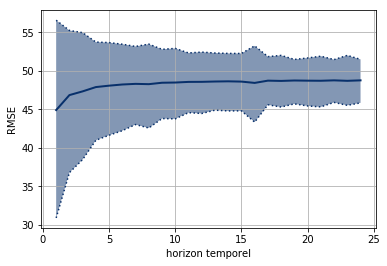

In [0]:
forwardNN(model=model,ville='PARIS',polluant='NO2',dataset=pollutant,meteo_ds=meteo,backward=6,forward=24)

Instructions for updating:
Use tf.cast instead.


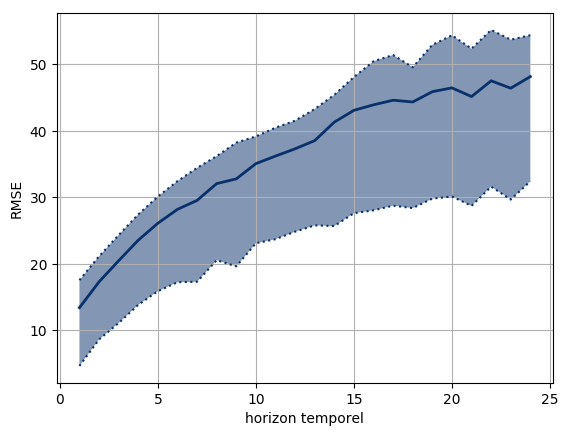

In [0]:
forwardNN(model=model,ville='BEIJING',polluant='PM10',dataset=pollutant,meteo_ds=meteo,backward=6,forward=24)

In [0]:
def forwardNNPlot(model,ville,polluant, backward,forward,dataset,meteo_ds):
  
  df,labels = preprocess(ville=ville,polluant=polluant,
                         backward=backward,forward=forward,
                         dataset=dataset,meteo_ds=meteo_ds,
                         method='series')
  df,labels = df.values,labels.values
 
  colormap = plt.get_cmap('Blues_r')
  plt.grid(True)
  
    
  RMSE_list = np.zeros(forward)
  for train, test in TimeSeriesSplit(3).split(df):
    rbase = np.zeros((len(test),1))
    model.fit(df[train],labels[train],epochs=100,verbose=0)
    ypred = model.predict(df[test])
    for i in range(1,forward+1):
      if i==1:
        r = np.sqrt((labels[test][:,:i]-ypred[:,:i])**2)
      else:
        ytrue = labels[test][:,:i].reshape((i,len(test)))
        ypred_restr = ypred[:,:i].reshape((i,len(test)))
        r = np.sqrt(mean_squared_error(ytrue,ypred_restr,multioutput='raw_values'))
      rbase = np.column_stack((rbase,r.reshape((len(r),1)))) 
    RMSE_list = np.row_stack((RMSE_list,rbase[:,1:]))

  y_pred = np.append(ypred[26,:],ypred[27,:])
  y_pred = np.append(y_pred,ypred[28,:])
  labels_pred = np.append(labels[test][26,:],labels[test][27,:])
  labels_pred = np.append(labels_pred,labels[test][28,:])
  plt.plot(np.arange(1,24*3+1),y_pred,color='b',alpha=0.5)
  plt.plot(np.arange(1,24*3+1),labels_pred,color='r',alpha=0.5)
  plt.xlabel('Heures')
  plt.ylabel('Valeurs')

  return None
  

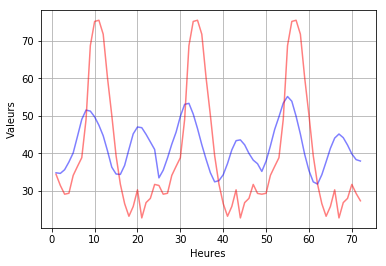

In [0]:
forwardNNPlot(model=model,ville='PARIS',polluant='NO2',dataset=pollutant,meteo_ds=meteo,backward=6,forward=24)

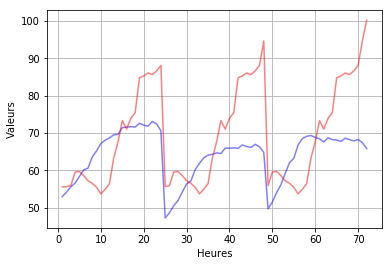

In [0]:
forwardNNPlot(model=model,ville='BEIJING',polluant='PM10',dataset=pollutant,meteo_ds=meteo,backward=6,forward=24)

In [0]:
def forwardNNPlot24(model,ville,polluant, backward,forward,dataset,meteo_ds):
  
  df,labels = preprocess(ville=ville,polluant=polluant,
                         backward=backward,forward=forward,
                         dataset=dataset,meteo_ds=meteo_ds,
                         method='series')
  df,labels = df.values,labels.values
 
  colormap = plt.get_cmap('Blues_r')
  plt.grid(True)
  
    
  RMSE_list = np.zeros(forward)
  for train, test in TimeSeriesSplit(3).split(df):
    rbase = np.zeros((len(test),1))
    model.fit(df[train],labels[train],epochs=100,verbose=0)
    ypred = model.predict(df[test])
    for i in range(1,forward+1):
      if i==1:
        r = np.sqrt((labels[test][:,:i]-ypred[:,:i])**2)
      else:
        ytrue = labels[test][:,:i].reshape((i,len(test)))
        ypred_restr = ypred[:,:i].reshape((i,len(test)))
        r = np.sqrt(mean_squared_error(ytrue,ypred_restr,multioutput='raw_values'))
      rbase = np.column_stack((rbase,r.reshape((len(r),1)))) 
    RMSE_list = np.row_stack((RMSE_list,rbase[:,1:]))
  
  print(ypred[:,:24])
  plt.plot(np.arange(1,len(labels[test])+1),ypred[:,:24],color='b',alpha=0.01)
  plt.plot(np.arange(1,len(labels[test])+1),labels[test][:,:24],color='r',alpha=0.01)
  plt.xlabel('Observations')
  plt.ylabel('Valeurs')

  return None

[[74.22131  62.85721  55.49798  ... 48.531506 59.520264 67.20946 ]
 [71.07754  62.89333  58.216522 ... 48.579    57.80804  61.810005]
 [59.114357 54.305515 51.598763 ... 48.99411  50.22792  49.748505]
 ...
 [54.68451  52.028767 50.359753 ... 68.374916 66.24212  64.11009 ]
 [44.875732 41.829693 41.816666 ... 54.34218  51.41771  48.124283]
 [38.235264 34.722183 35.583096 ... 51.17763  47.155384 42.724617]]


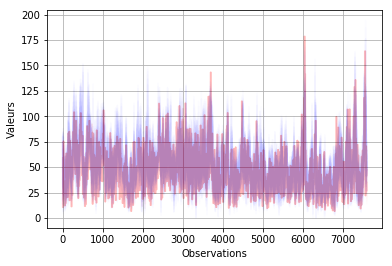

In [0]:
forwardNNPlot24(model,ville='PARIS',polluant='NO2',dataset=pollutant,meteo_ds=meteo,backward=6,forward=24)

# Multitask

In [0]:
def evaluate1Poll(polluant,model,df,labels,forward,backward,method,ft_list='all'):
  
    df_p, labels_p = preprocess('PARIS',polluant,backward,forward,method,pollutant,meteo)
    df_b, labels_b = preprocess('BEIJING',polluant,backward,forward,method,pollutant,meteo)
    
    splits = TimeSeriesSplit(n_splits=3)
    RMSE_list = []
    train_error = []
    
    df_p = df_p.values
    labels_p = labels_p.values
    df_b = df_b.values
    labels_b = labels_b.values
    
    if ft_list=='all':
      m=8
    else: 
      m = len(ft_list)
    
    for (train_p,test_p),(train_b,test_b) in zip(splits.split(df_p),splits.split(df_b)):
      
        dftrain = []
        labelstrain = []
        dftest = []
        labelstest = []
        
        dftrain = np.concatenate((df_p[train_p],df_b[train_b]), axis=0)
        labelstrain = np.concatenate((labels_p[train_p],labels_b[train_b]), axis=0)
      
        dftest = np.concatenate((df_p[test_p],df_b[test_b]), axis=0)
        labelstest = np.concatenate((labels_p[test_p],labels_b[test_b]), axis=0)
        
        if method == 'single' or method == 'series':
            model.fit(dftrain,labelstrain)
            ypred = model.predict(dftest)
            RMSE_list.append(np.sqrt(mean_squared_error(labelstest,ypred)))
    
    return np.mean(RMSE_list)

#6. Prédiction multivariée

Meilleur $\alpha$ pour le lasso en series: 
- paris NO2 2
- paris PM10 1
- beijing NO2 2,4
- beijing PM10 22,4

Meilleur  𝛼  pour le ridge en series:

- paris NO2 2145
- paris PM10 8580
- beijing NO2 89
- beijing PM10 920

In [0]:
def seriesForwardGraph(ville, polluant,models,backward,forward,dataset,meteo_ds,names):
  
  df,labels = preprocess(ville=ville,polluant=polluant,
                         backward=backward,forward=forward,
                         dataset=dataset,meteo_ds=meteo_ds,
                         method='series')
  df,labels = df.values,labels.values
  n = int(np.ceil(len(models)/2))
  if n>1:
    fig = plt.figure(figsize=(20,len(models)*3))
  else: 
    fig = plt.figure(figsize=(5,len(models)*3))
    
  #plt.title('RMSE en fonction du temps pour {} à {}'.format(polluant,ville))
  colormap = plt.get_cmap('inferno')
  colormap = plt.get_cmap('Blues_r')
  plt.grid(True)
  for j,model in enumerate(models): 
    
    RMSE_list = np.zeros(forward)
    for train, test in TimeSeriesSplit(3).split(df):
      rbase = np.zeros((len(test),1))
      model.fit(df[train],labels[train])
      ypred = model.predict(df[test])
      for i in range(1,forward+1):
        if i==1:
          r = np.sqrt((labels[test][:,:i]-ypred[:,:i])**2)
        else:
          ytrue = labels[test][:,:i].reshape((i,len(test)))
          ypred_restr = ypred[:,:i].reshape((i,len(test)))
          r = np.sqrt(mean_squared_error(ytrue,ypred_restr,multioutput='raw_values'))
        rbase = np.column_stack((rbase,r.reshape((len(r),1)))) 
      RMSE_list = np.row_stack((RMSE_list,rbase[:,1:]))
      
    rl = RMSE_list[1:]
    rmse_m = np.mean(rl,axis=0)
    rmse_uq = np.percentile(rl,axis=0,q=75)
    rmse_lq = np.percentile(rl,axis=0,q=25)
    if n>1:
      ax = fig.add_subplot(n,2,j+1)
    else: 
      ax = fig.add_subplot(111)
    color = colormap(j/len(models))
    name = names[j]
    ax.plot(np.arange(1,forward+1),rmse_m,linewidth=2,c=color)
    ax.plot(np.arange(1,forward+1),rmse_uq,c = color,ls='dotted')
    ax.plot(np.arange(1,forward+1),rmse_lq,c=color,ls='dotted')
    ax.set_xlabel('horizon temporel')
    ax.set_ylabel('RMSE')
    ax.fill_between(np.arange(1,forward+1),
                     rmse_lq,
                     rmse_uq,
                     facecolor = color,
                     alpha = 0.5)
    ax.set_title(name)
    

  return None  

In [0]:
df,labels = preprocess(ville='PARIS',polluant='NO2',backward=6,forward=24,method='series',dataset=pollutant,meteo_ds=meteo)
dfi,labelsi = df.values,labels.values

In [0]:
n_estimators = [50,100]
max_features = ['auto', 'sqrt']
max_depth = [10,50]
min_samples_split = [50,100,500]
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
              }
ts_cv = TimeSeriesSplit(2).split(dfi)
scorer = make_scorer(score_func = mean_squared_error,greater_is_better=False)

grid = GridSearchCV(RandomForestRegressor(random_state=0), random_grid, n_jobs=-1, 
                    cv=ts_cv,verbose=10,scoring = scorer)
grid.fit(dfi,labelsi)
grid.best_params_

Fitting 2 folds for each of 24 candidates, totalling 48 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:  7.2min
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed: 18.3min
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed: 21.2min
[Parallel(n_jobs=-1)]: Done  21 tasks      | elapsed: 23.3min
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed: 33.5min
/usr/local/lib/python3.6/dist-packages/sklearn/externals/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed: 50.4min
[Parallel(n_jobs=-1)]: Done  48 out of  48 | elapsed: 52.8min finished


{'max_depth': 50,
 'max_features': 'auto',
 'min_samples_split': 50,
 'n_estimators': 100}

In [0]:
best_rf = RandomForestRegressor(random_state=0,max_depth=50,max_features='auto',min_samples_split=50,n_estimators=100)

In [0]:
model = RandomForestRegressor(random_state=0,max_depth=50,max_features='auto',min_samples_split=50,n_estimators=100)
evaluate1Ville1Poll(model=model, backward=6,forward=24,method='series',df=df,labels=labels)

(16.80094978733671,
 0.5454365549170296,
 array([16.45515371, 17.12177245]),
 0.6138935360695491,
 0.01721389132815354,
 array([0.60531885, 0.62566255]))

## Beijing PM10

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


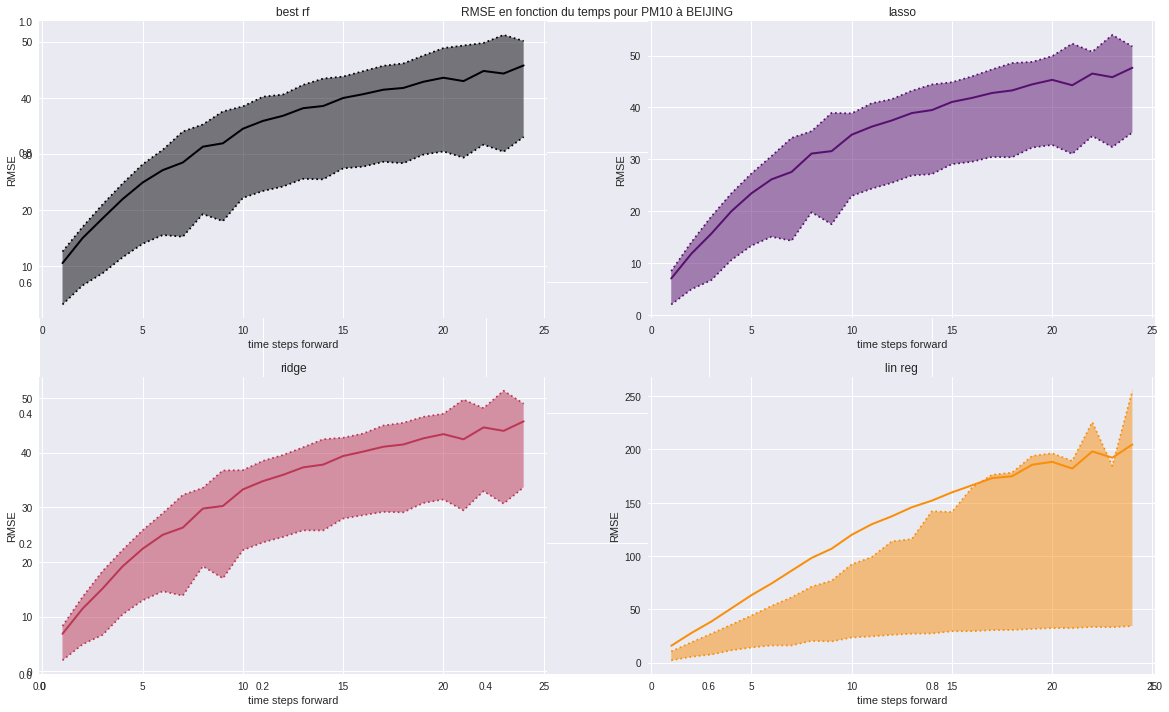

In [0]:
seriesForwardGraph(ville='BEIJING',polluant='PM10',models=[best_rf,Lasso(alpha=22.4),Ridge(alpha=920),LinearRegression()],
                   backward=6,forward=24,dataset=pollutant,meteo_ds=meteo,names=['best rf','lasso','ridge','lin reg'])

## Beijing NO2

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


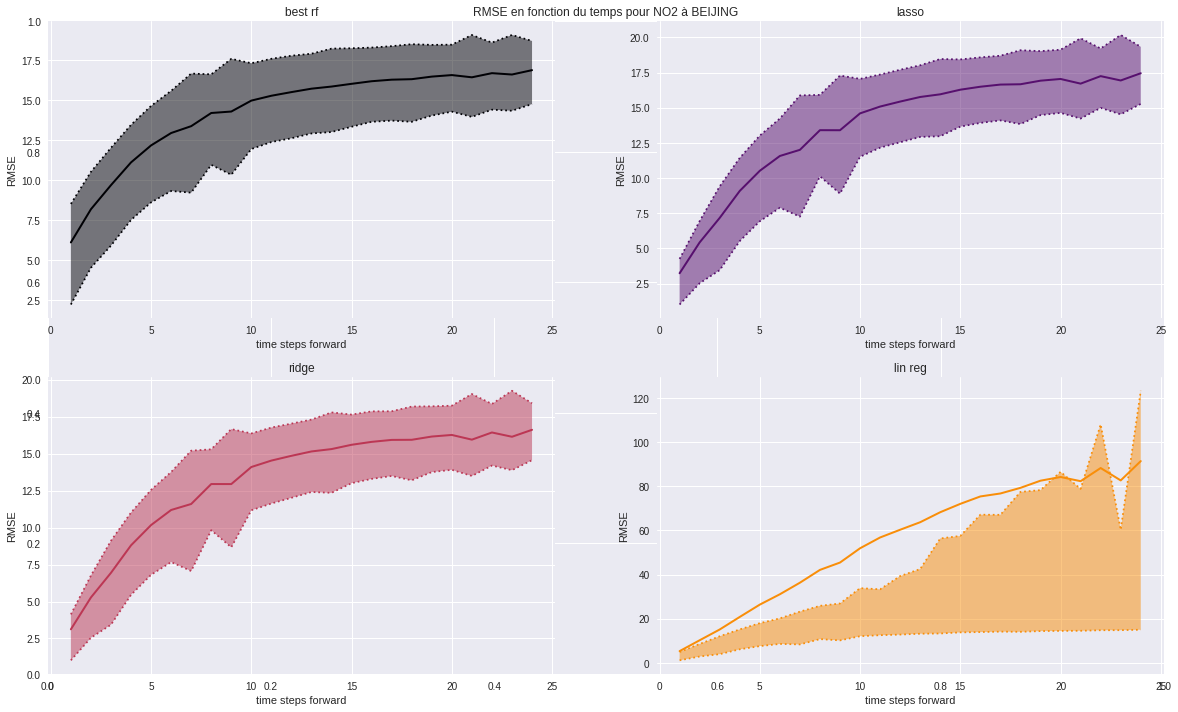

In [0]:
seriesForwardGraph(ville='BEIJING',polluant='NO2',models=[best_rf,Lasso(alpha=2.4),Ridge(alpha=89),LinearRegression()],
                   backward=6,forward=24,dataset=pollutant,meteo_ds=meteo,names=['best rf','lasso','ridge','lin reg'])

## Paris NO2

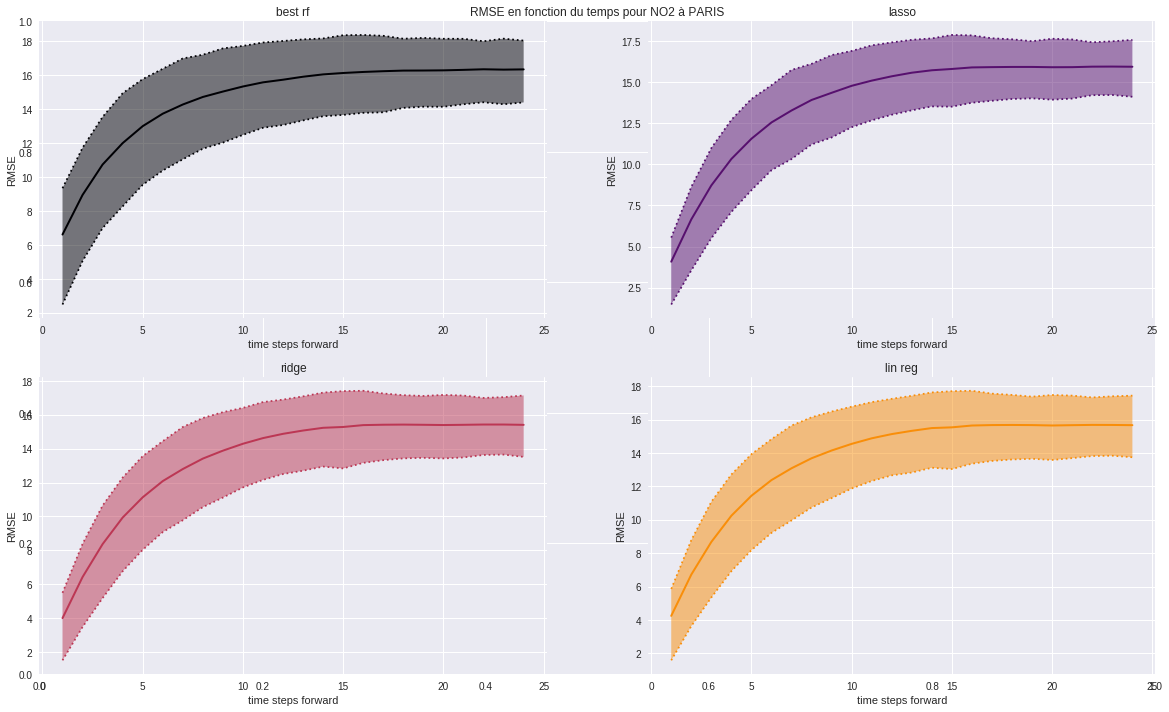

In [0]:
seriesForwardGraph(ville='PARIS',polluant='NO2',models=[best_rf,Lasso(alpha=2),Ridge(alpha=2145),LinearRegression()],
                   backward=6,forward=24,dataset=pollutant,meteo_ds=meteo,names=['best rf','lasso','ridge','lin reg'])

## Paris PM10

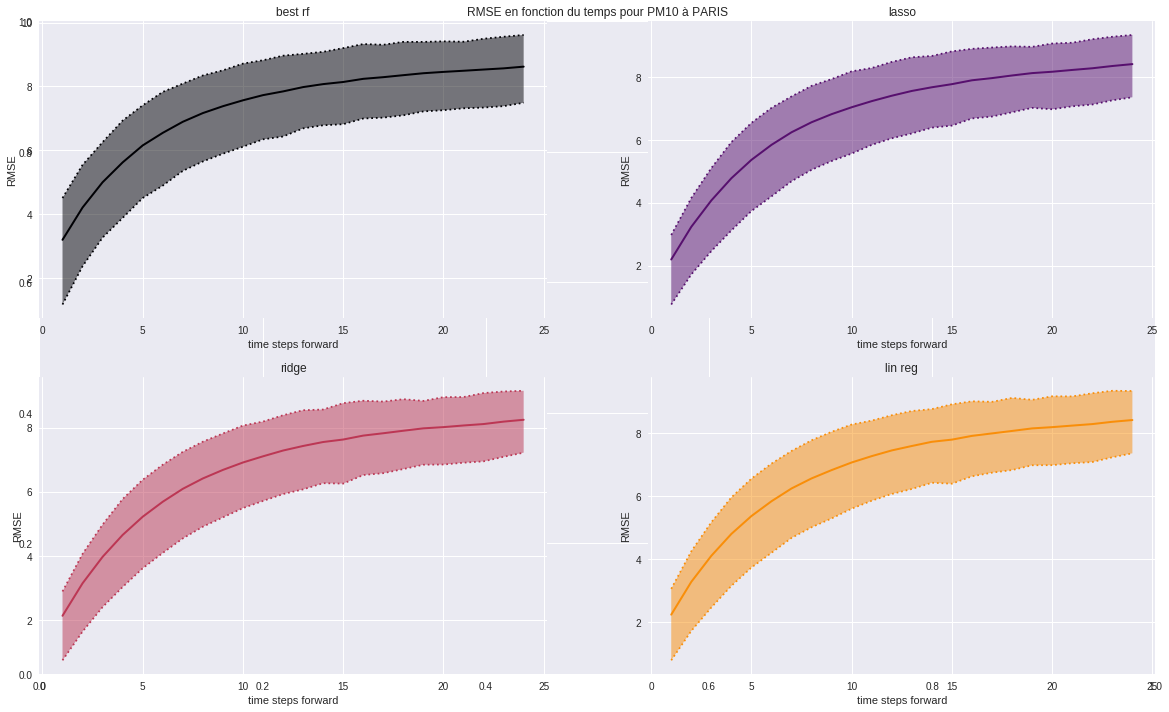

In [0]:
seriesForwardGraph(ville='PARIS',polluant='PM10',models=[best_rf,Lasso(alpha=1),Ridge(alpha=8580),LinearRegression()],
                   backward=6,forward=24,dataset=pollutant,meteo_ds=meteo,names=['best rf','lasso','ridge','lin reg'])

In [0]:
def seriesForwardPlot(ville,polluant,models,backward,forward,dataset,meteo_ds,names):
  
  df,labels = preprocess(ville=ville,polluant=polluant,
                         backward=backward,forward=forward,
                         dataset=dataset,meteo_ds=meteo_ds,
                         method='series')
  df,labels = df.values,labels.values

  colormap = plt.get_cmap('Blues_r')
  plt.grid(True)
  for j,model in enumerate(models): 
    
    RMSE_list = np.zeros(forward)
    for train, test in TimeSeriesSplit(3).split(df):
      rbase = np.zeros((len(test),1))
      model.fit(df[train],labels[train])
      ypred = model.predict(df[test])
      for i in range(1,forward+1):
        if i==1:
          r = np.sqrt((labels[test][:,:i]-ypred[:,:i])**2)
        else:
          ytrue = labels[test][:,:i].reshape((i,len(test)))
          ypred_restr = ypred[:,:i].reshape((i,len(test)))
          r = np.sqrt(mean_squared_error(ytrue,ypred_restr,multioutput='raw_values'))
        rbase = np.column_stack((rbase,r.reshape((len(r),1)))) 
      RMSE_list = np.row_stack((RMSE_list,rbase[:,1:]))
    
    x = np.arange(1,len(labels[test])+1)
    plt.plot(x,ypred[:,:24],color='b',alpha=0.01)
    plt.plot(x,labels[test][:,:24],color='r',alpha=0.01)
    plt.xlabel('Observations')
    plt.ylabel('Valeurs')
    plt.legend()
  return None  

No handles with labels found to put in legend.


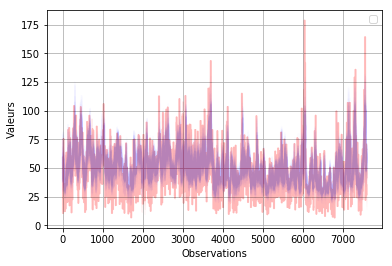

In [0]:
seriesForwardPlot(ville='PARIS',polluant='NO2',models=[best_rf],backward=6,forward=24,dataset=pollutant,meteo_ds=meteo,names=[''])

In [0]:
def seriesForwardPlot24(ville,polluant,models,backward,forward,dataset,meteo_ds,names):
  
  df,labels = preprocess(ville=ville,polluant=polluant,
                         backward=backward,forward=forward,
                         dataset=dataset,meteo_ds=meteo_ds,
                         method='series')
  df,labels = df.values,labels.values
  #n = int(np.ceil(len(models)/2))
  #if n>1:
  #  fig = plt.figure(figsize=(20,len(models)*3))
  #else: 
  #plt.title('RMSE en fonction du temps pour {} à {}'.format(polluant,ville))
  #colormap = plt.get_cmap('inferno')
  colormap = plt.get_cmap('Blues_r')
  plt.grid(True)
  for j,model in enumerate(models): 
    
    RMSE_list = np.zeros(forward)
    for train, test in TimeSeriesSplit(3).split(df):
      rbase = np.zeros((len(test),1))
      model.fit(df[train],labels[train])
      ypred = model.predict(df[test])
      for i in range(1,forward+1):
        if i==1:
          r = np.sqrt((labels[test][:,:i]-ypred[:,:i])**2)
        else:
          ytrue = labels[test][:,:i].reshape((i,len(test)))
          ypred_restr = ypred[:,:i].reshape((i,len(test)))
          r = np.sqrt(mean_squared_error(ytrue,ypred_restr,multioutput='raw_values'))
        rbase = np.column_stack((rbase,r.reshape((len(r),1)))) 
      RMSE_list = np.row_stack((RMSE_list,rbase[:,1:]))
    
    y_pred = np.append(ypred[26,:],ypred[27,:])
    y_pred = np.append(y_pred,ypred[28,:])
    labels_pred = np.append(labels[test][26,:],labels[test][27,:])
    labels_pred = np.append(labels_pred,labels[test][28,:])
    x = np.arange(1,24*3+1)
    plt.plot(x,y_pred,color='b',alpha=0.5)
    plt.plot(x,labels_pred,color='r',alpha=0.5)
    plt.xlabel('Heures')
    plt.ylabel('Valeurs')
    
  return None  

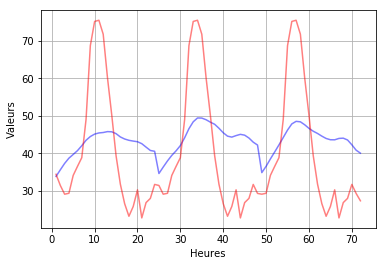

In [0]:
seriesForwardPlot24(ville='PARIS',polluant='NO2',models=[best_rf],backward=6,forward=24,dataset=pollutant,meteo_ds=meteo,names=[''])

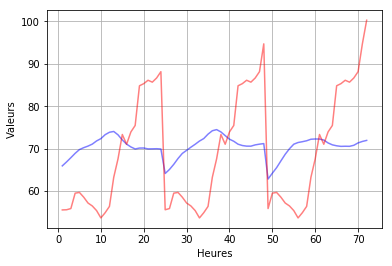

In [0]:
seriesForwardPlot24(ville='BEIJING',polluant='PM10',models=[best_rf],backward=6,forward=24,dataset=pollutant,meteo_ds=meteo,names=[''])

# Figures

/usr/local/lib/python3.6/dist-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "


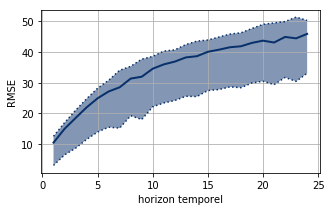

In [0]:
seriesForwardGraph(ville='BEIJING',polluant='PM10',models=[best_rf],
                   backward=6,forward=24,dataset=pollutant,meteo_ds=meteo,names=[''])

/usr/local/lib/python3.6/dist-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "


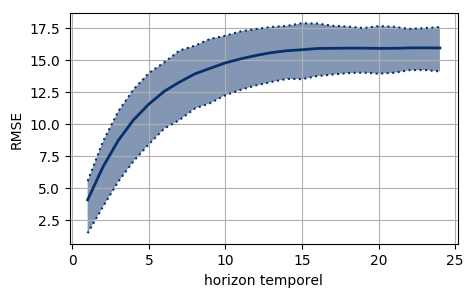

In [0]:
seriesForwardGraph(ville='PARIS',polluant='NO2',models=[Lasso(alpha=2)],
                   backward=6,forward=24,dataset=pollutant,meteo_ds=meteo,names=[''])

/usr/local/lib/python3.6/dist-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "


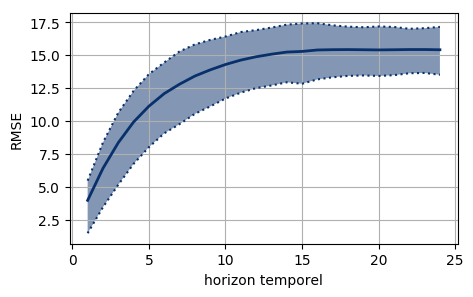

In [0]:
seriesForwardGraph(ville='PARIS',polluant='NO2',models=[Ridge(alpha=2145)],
                   backward=6,forward=24,dataset=pollutant,meteo_ds=meteo,names=[''])

/usr/local/lib/python3.6/dist-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "


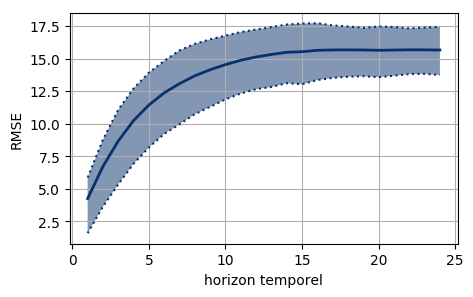

In [0]:
seriesForwardGraph(ville='PARIS',polluant='NO2',models=[LinearRegression()],
                   backward=6,forward=24,dataset=pollutant,meteo_ds=meteo,names=[''])

/usr/local/lib/python3.6/dist-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "


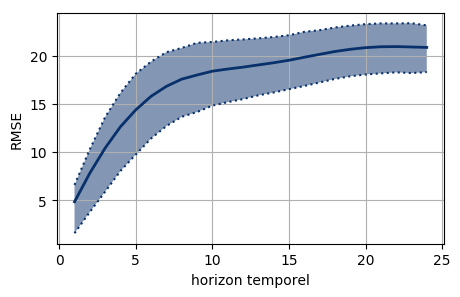

In [0]:
seriesForwardGraph(ville='PARIS',polluant='NO2',models=[PreviousPredictor(6)],
                   backward=6,forward=24,dataset=pollutant,meteo_ds=meteo,names=[''])

In [0]:
seriesForwardGraph(ville='PARIS',polluant='NO2',models=[MeanPredictor(6)],
                   backward=6,forward=24,dataset=pollutant,meteo_ds=meteo,names=[''])

/usr/local/lib/python3.6/dist-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "


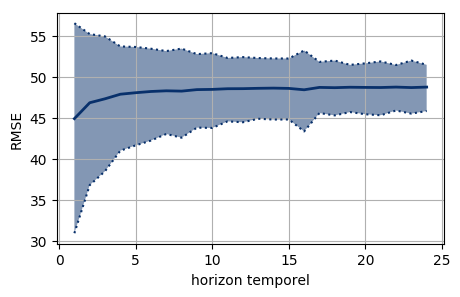

In [0]:
seriesForwardGraph(ville='PARIS',polluant='NO2',models=[NullPredictor(0)],
                   backward=6,forward=24,dataset=pollutant,meteo_ds=meteo,names=[''])

# MULTITASK LEARNING 

In [0]:
  def forwardSeriesMTL(dataset,forward_shift):
    res = dataset.copy()
    for shift in range(1,forward_shift+1):
      for feature in dataset.columns:
          if feature not in ['zone','date']:
                res[feature+'_H+'+str(shift)] = res.sort_values(['zone','date']).groupby(['zone'])[feature].shift(-shift)

    for feature in dataset.columns:
      
      if feature not in ['zone','date']:
        try:
           res = res.drop([feature],axis=1) 
        except: 
          pass
        
    return res

In [0]:
def preprocessMTL(ville, pollist,backward,forward,dataset,meteo_ds):
   
    #prepare dataset, labels
    l = ['date','zone']+pollist
    pollutant = dataset[dataset.zone==ville][l] 
    m = len(meteo_ds.columns.drop(['date','zone'])) #servira plus loin, normalement vaut 8
    
    #shift datasets    
    dfpoll = shifted_dataset(pollutant,backward,forward_shift=0)
    dfmeteo = shifted_dataset(meteo,backward,forward_shift=forward)
    
        
    df = pd.merge(dfpoll,dfmeteo,how = 'inner', on=['date']).drop_duplicates(subset='date')
    
    axes = df[['date']].drop_duplicates() #on garde pour restreindre les labels par la suite
    
    try:
        df = df.drop(['date','zone_x','zone_y'],axis=1)
    except:
        df = df.drop(['date','zone'],axis=1)
        
    df = df.fillna(method='bfill',axis=0)
    df = df.fillna(method='ffill',axis=0)
    
    #prepare labels 
    labels = forwardSeries(pollutant,forward).drop_duplicates(subset='date')
    labels = axes.merge(labels,how='inner',on=['date'])
    
    #labels = labels.drop(['date'],axis=1)[[polluant+'_H+'+str(i) for i in range(1,forward+1)]]
    
    labels = labels.drop(['date','zone'],axis=1)
    labels = labels.fillna(method='bfill',axis=0)
    labels = labels.fillna(method='ffill',axis=0)
    
    return df,labels

In [0]:
def evaluateNN(model,df,labels):

    splits = TimeSeriesSplit(n_splits=3)
    RMSE_list = []
    df = df.values

    lbNO2 = labels[labels.columns[labels.columns.str.contains('NO2')]].values.reshape((labels.shape[0],24))
    lbPM10 = labels[labels.columns[labels.columns.str.contains('PM10')]].values.reshape((labels.shape[0],24))
    lbPM2_5 = labels[labels.columns[labels.columns.str.contains('PM2_5')]].values.reshape((labels.shape[0],24))
    lbO3 = labels[labels.columns[labels.columns.str.contains('O3')]].values.reshape((labels.shape[0],24))
    #labels = np.array(labels.values).reshape((labels.shape[0],4,3))
    
    for train,test in splits.split(df):
      
        #callbacks = [EarlyStopping(monitor='val_loss', mode='min'),
        #            ModelCheckpoint(filepath='best_model.h5', monitor='val_loss', save_best_only=True)]    
        #model.fit(df[train],labels[train],callbacks=callbacks,epochs=200)
        model.fit(df[train],[lbNO2[train],lbPM10[train],lbPM2_5[train],lbO3[train]],
                  epochs=200,verbose=0)
        #ypred = model.predict(df[test])
        score = model.evaluate(x = df[test],y = [lbNO2[test],lbPM10[test],lbPM2_5[test],lbO3[test]])
        rmse = np.sqrt(score[1:])
        RMSE_list.append(rmse)
       
    return np.mean(RMSE_list,axis=0)

In [0]:
df,labels = preprocessMTL(ville='PARIS',pollist=['NO2','PM10','PM2_5','O3'],backward=6,forward=24,dataset=pollutant,meteo_ds=meteo)

In [0]:
labels.columns

In [0]:
df.columns

In [0]:
from keras.layers import Input, Embedding, LSTM, Dense
from keras.models import Model

Using TensorFlow backend.


In [0]:
labels.values.reshape((labels.shape[0],4,3))[0]

array([[73.94180298, 70.77287292, 68.12986755],
       [35.57971573, 34.84990311, 34.15850449],
       [14.93360233, 14.74126434, 14.59227562],
       [19.87198377, 19.87198377, 19.87198377]])

In [0]:
n = df.shape[1]
x = Input(shape=(n, ))
shared1 = Dense(100)(x)
shared2 = Dense(100)(shared1)
sub1 = Dense(50)(shared2)
sub2 = Dense(50)(shared2)
sub3 = Dense(50)(shared2)
sub4 = Dense(50)(shared2)
out = labels.shape[1]//4
out1 = Dense(out,name='NO2')(sub1)
out2 = Dense(out,name='PM10')(sub2)
out3 = Dense(out,name='PM2_5')(sub3)
out4 = Dense(out,name='O3')(sub4)

Instructions for updating:
Colocations handled automatically by placer.


In [0]:
model = Model(inputs=x,outputs=[out1, out2, out3, out4])

In [0]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 276)          0                                            
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 100)          27700       input_1[0][0]                    
__________________________________________________________________________________________________
dense_2 (Dense)                 (None, 100)          10100       dense_1[0][0]                    
__________________________________________________________________________________________________
dense_3 (Dense)                 (None, 50)           5050        dense_2[0][0]                    
__________________________________________________________________________________________________
dense_4 (D

In [0]:
model.compile(loss=['mse','mse','mse','mse'],optimizer = 'adam')

In [0]:
score = evaluateNN(model=model,df=df,labels=labels)
score

Instructions for updating:
Use tf.cast instead.
8858/8858 [==============================] - 0s 51us/step


array([17.96087624,  9.91022625,  7.39595834, 19.17633779])

In [0]:
#Non terminée
def forwardMTL(model,ville, backward,forward,dataset,meteo_ds):
  
  df,labels = preprocessMTL(ville, pollist,backward,forward,dataset,meteo_ds)
  df,labels = df.values,labels.values
 
  colormap = plt.get_cmap('Blues_r')
  plt.grid(True)
  
  RMSE_list = np.zeros(forward)
  for train, test in TimeSeriesSplit(3).split(df):
    rbase = np.zeros((len(test),1))
    model.fit(df[train],[lbNO2[train],lbPM10[train],lbPM2_5[train],lbO3[train]],epochs=200,verbose=0)
    ypred = model.evaluate(x = df[test],y = [lbNO2[test],lbPM10[test],lbPM2_5[test],lbO3[test]])
    for i in range(1,forward+1):
      if i==1:
        r = np.sqrt((labels[test][:,:i]-ypred[:,:i])**2)
      else:
        ytrue = labels[test][:,:i].reshape((i,len(test)))
        ypred_restr = ypred[:,:i].reshape((i,len(test)))
        r = np.sqrt(mean_squared_error(ytrue,ypred_restr,multioutput='raw_values'))
      rbase = np.column_stack((rbase,r.reshape((len(r),1)))) 
    RMSE_list = np.row_stack((RMSE_list,rbase[:,1:]))

  rl = RMSE_list[1:]
  rmse_m = np.mean(rl,axis=0)
  rmse_uq = np.percentile(rl,axis=0,q=75)
  rmse_lq = np.percentile(rl,axis=0,q=25)
  color = colormap(0)
  plt.plot(np.arange(1,forward+1),rmse_m,linewidth=2,c=color)
  plt.plot(np.arange(1,forward+1),rmse_uq,c = color,ls='dotted')
  plt.plot(np.arange(1,forward+1),rmse_lq,c=color,ls='dotted')
  plt.xlabel('horizon temporel')
  plt.ylabel('RMSE')
  plt.fill_between(np.arange(1,forward+1),
                   rmse_lq,
                   rmse_uq,
                   facecolor = color,
                   alpha = 0.5)
  return None
  

#test d'ajout de tous les polluants comme features (H-6 à H-1)

In [0]:
def preprocesstest(ville, polluant,backward,forward,method,dataset,meteo_ds,ft_list='all'):
    """
    la méthode 'single' prédit sur uniquement t+forward
    la méthode 'series' prédit sur t+1,t+2,...,t+forward
    la méthode 'iter' prédit t+1 puis s'en sert pour prédire t+2 etc. jusqu'à t+forward
    """
    
    pollutant = dataset[dataset.zone==ville]
    if ft_list == 'all':
        meteo = meteo_ds.copy()[meteo_ds.zone==ville]
    else: 
        meteo = meteo_ds.copy()[meteo_ds.zone==ville][['zone','date']+ft_list]  
    m = len(meteo.columns.drop(['date','zone'])) #servira plus loin, normalement vaut 8
    
    #shift datasets    
    dfpoll = shifted_dataset(pollutant,backward,forward_shift=0)
    if method == 'single':
        dfmeteo = shifted_dataset(meteo,backward,forward_shift=1)
    elif method == 'series':
        dfmeteo = shifted_dataset(meteo,backward,forward_shift=forward)
    elif method == 'iter':
        dfmeteo = shifted_dataset(meteo,backward,forward_shift=forward)
    else:
        raise ValueError('method needs to be defined')
        
    df = pd.merge(dfpoll,dfmeteo,how = 'inner', on=['date']).drop_duplicates(subset='date')
    
    axes = df[['date']].drop_duplicates() #on garde pour restreindre les labels par la suite
    
    try:
        df = df.drop(['date','zone_x','zone_y'],axis=1)
    except:
        df = df.drop(['date','zone'],axis=1)
        
    df = df.fillna(method='bfill',axis=0)
    df = df.fillna(method='ffill',axis=0)
    
    #prepare labels 
    labels = forwardSeries(pollutant,forward).drop_duplicates(subset='date')
    labels = axes.merge(labels,how='inner',on=['date'])
    if method == 'single':
        labels = labels.drop(['date'],axis=1)[polluant+'_H+'+str(forward)]
    elif method == 'series' or method=='iter':
        labels = labels.drop(['date'],axis=1)[[polluant+'_H+'+str(i) for i in range(1,forward+1)]]
    
    labels = labels.fillna(method='bfill',axis=0)
    labels = labels.fillna(method='ffill',axis=0)
    
    return df,labels

In [0]:
df,labels = preprocesstest(ville='PARIS', polluant='NO2',backward=6,forward=24,method='series',dataset=pollutant,meteo_ds=meteo,ft_list='all')
df.columns

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


Index(['NO2_H-6', 'PM10_H-6', 'PM2_5_H-6', 'O3_H-6', 'NO2_H-5', 'PM10_H-5',
       'PM2_5_H-5', 'O3_H-5', 'NO2_H-4', 'PM10_H-4',
       ...
       'windbearingsin_H+23', 'windspeed_H+23', 'temperature_H+24',
       'precipintensity_H+24', 'cloudcover_H+24', 'pressure_H+24',
       'windbearingcos_H+24', 'precipprobability_H+24', 'windbearingsin_H+24',
       'windspeed_H+24'],
      dtype='object', length=276)

In [0]:
def seriesForwardGraphtest(ville, polluant,models,backward,forward,dataset,meteo_ds,names):
  
  df,labels = preprocesstest(ville=ville,polluant=polluant,
                         backward=backward,forward=forward,
                         dataset=dataset,meteo_ds=meteo_ds,
                         method='series')
  df,labels = df.values,labels.values
  n = int(np.ceil(len(models)/2))
  if n>1:
    fig = plt.figure(figsize=(20,len(models)*3))
  else: 
    fig = plt.figure(figsize=(5,len(models)*3))
    
  #plt.title('RMSE en fonction du temps pour {} à {}'.format(polluant,ville))
  colormap = plt.get_cmap('inferno')
  colormap = plt.get_cmap('Blues_r')
  plt.grid(True)
  for j,model in enumerate(models): 
    
    RMSE_list = np.zeros(forward)
    for train, test in TimeSeriesSplit(3).split(df):
      rbase = np.zeros((len(test),1))
      model.fit(df[train],labels[train])
      ypred = model.predict(df[test])
      for i in range(1,forward+1):
        if i==1:
          r = np.sqrt((labels[test][:,:i]-ypred[:,:i])**2)
        else:
          ytrue = labels[test][:,:i].reshape((i,len(test)))
          ypred_restr = ypred[:,:i].reshape((i,len(test)))
          r = np.sqrt(mean_squared_error(ytrue,ypred_restr,multioutput='raw_values'))
        rbase = np.column_stack((rbase,r.reshape((len(r),1)))) 
      RMSE_list = np.row_stack((RMSE_list,rbase[:,1:]))
      
    rl = RMSE_list[1:]
    rmse_m = np.mean(rl,axis=0)
    rmse_uq = np.percentile(rl,axis=0,q=75)
    rmse_lq = np.percentile(rl,axis=0,q=25)
    if n>1:
      ax = fig.add_subplot(n,2,j+1)
    else: 
      ax = fig.add_subplot(111)
    color = colormap(j/len(models))
    name = names[j]
    ax.plot(np.arange(1,forward+1),rmse_m,linewidth=2,c=color)
    ax.plot(np.arange(1,forward+1),rmse_uq,c = color,ls='dotted')
    ax.plot(np.arange(1,forward+1),rmse_lq,c=color,ls='dotted')
    ax.set_xlabel('horizon temporel')
    ax.set_ylabel('RMSE')
    ax.fill_between(np.arange(1,forward+1),
                     rmse_lq,
                     rmse_uq,
                     facecolor = color,
                     alpha = 0.5)
    ax.set_title(name)
    

  return None  

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """
/usr/local/lib/python3.6/dist-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "


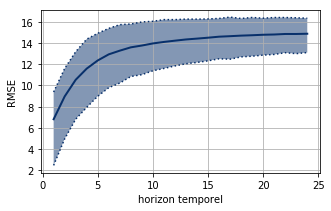

In [0]:
seriesForwardGraphtest(ville='PARIS',polluant='NO2',models=[best_rf],backward=6,forward=24,dataset=pollutant,meteo_ds=meteo,names=[''])

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """
/usr/local/lib/python3.6/dist-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "


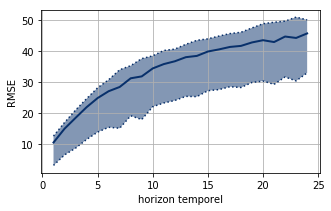

In [0]:
seriesForwardGraphtest(ville='BEIJING',polluant='PM10',models=[best_rf],backward=6,forward=24,dataset=pollutant,meteo_ds=meteo,names=[''])